In [2]:
import os
import torch
import pickle
from skimage import io
import matplotlib.pyplot as plt
from torchvision.models import resnet152
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Normalize, Resize, Rotate, HorizontalFlip, RandomCrop
from dataset import CustomDataset
# from model import DepthEstimationNet, ModifiedBlock
# from training import train_model, DBELoss, get_training_augmentation, get_validation_augmentation, setup_logging
# from fourier_analysis import FDC
from torch import optim
import numpy as np
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import torch
import torch.nn as nn
from torchvision.models import resnet152
import torch.nn.functional as F
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from albumentations import Compose, HorizontalFlip, Resize, Normalize, Rotate, RandomCrop
from albumentations.pytorch import ToTensorV2
from dataset import CustomDataset
# from model import DepthEstimationNet
import copy
import logging
from torchinfo import summary
import math
from skimage import transform



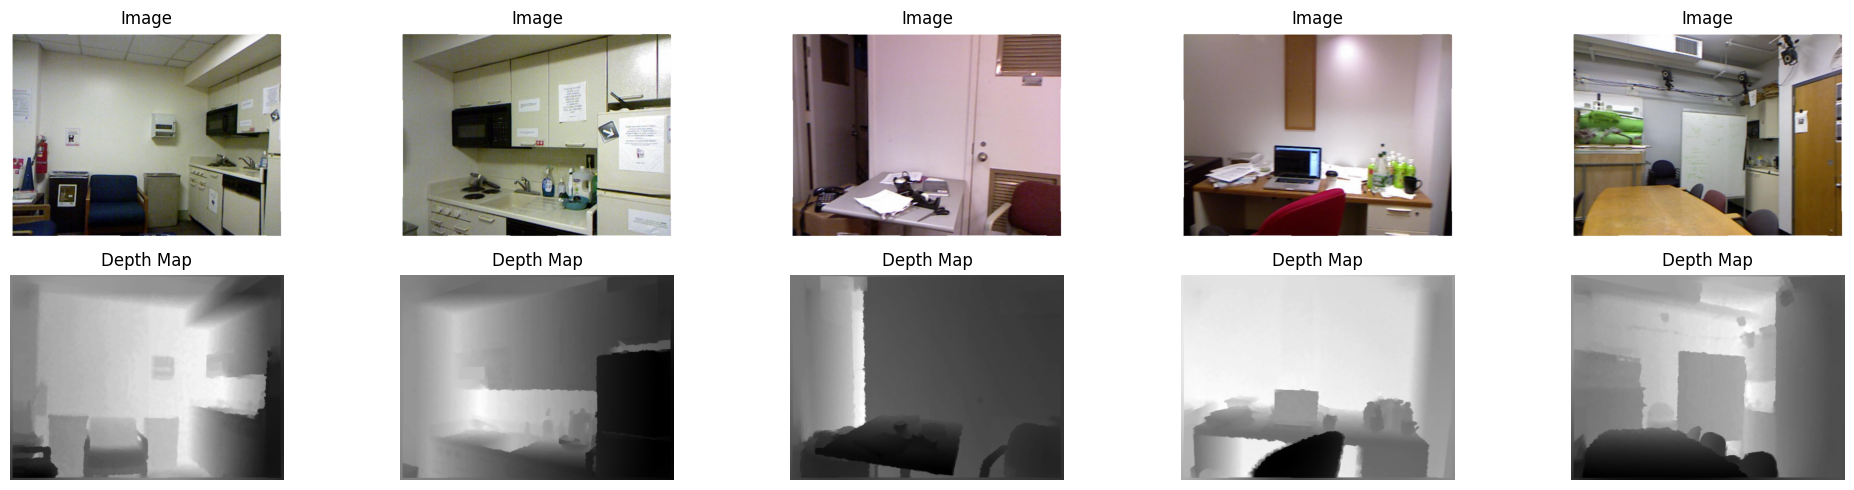

Image shape: (480, 640, 3)
Depth shape: (480, 640)


In [3]:
def display_samples(data_dir, num_samples=5):
    images_dir = os.path.join(data_dir, 'images/train')
    depths_dir = os.path.join(data_dir, 'depths/train')
    image_paths = sorted([os.path.join(images_dir, name) for name in os.listdir(images_dir) if name.endswith('.p')])
    depth_paths = sorted([os.path.join(depths_dir, name) for name in os.listdir(depths_dir) if name.endswith('.p')])

    plt.figure(figsize=(20, 5))
    for i in range(num_samples):
        image = pickle.load(open(image_paths[i], 'rb'))
        depth = pickle.load(open(depth_paths[i], 'rb'))
        
        # If images are floats in [0, 255] range, we need to convert to uint8
        image = image.astype('uint8')
        
        # Display image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        # Display depth map - normalize to [0, 1] range for display purposes
        normalized_depth = (depth - depth.min()) / (depth.max() - depth.min())
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(normalized_depth, cmap='gray')
        plt.title('Depth Map')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

data_dir = './data/nyu_v2'
display_samples(data_dir)

# data shape
image = pickle.load(open('./data/nyu_v2/images/train/00000.p', 'rb'))
depth = pickle.load(open('./data/nyu_v2/depths/train/00000.p', 'rb'))
print(f'Image shape: {image.shape}')
print(f'Depth shape: {depth.shape}')

# expected output
# Image shape: (480, 640, 3)
# Depth shape: (480, 640)


In [4]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')


In [5]:
device

device(type='mps')

In [6]:
project_dir = os.getcwd()
save_dir = os.path.join(project_dir, 'models', 'training_runs')
os.makedirs(save_dir, exist_ok=True)
# setup_logging(save_dir)

## DepthModelNet

In [7]:
class ModifiedBlock(nn.Module):
    def __init__(self, in_channels, out_channels, device, Aux_output_channels = None):
        super(ModifiedBlock, self).__init__()
        self.device = device
        # Bc,c'
        self.is_B_cc_prime = Aux_output_channels is not None
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, 1).to(self.device)
        self.bn1 = nn.BatchNorm2d(out_channels//4).to(self.device)
        self.relu = nn.ReLU(inplace=True).to(self.device)
        self.conv2 = nn.Conv2d(out_channels//4, out_channels//4, 3, padding=1).to(self.device)
        self.bn2 = nn.BatchNorm2d(out_channels//4).to(self.device)
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, 1).to(self.device)
        self.bn3 = nn.BatchNorm2d(out_channels).to(self.device)
        
        # for B' Blocks 
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels ,eps=1e-05, momentum=0.1, affine=True)
        ).to(self.device) if in_channels != out_channels else None
        
        #  for Bc,c' Blocks
        if self.is_B_cc_prime:
            self._Aux_Conv1 = nn.Conv2d(out_channels, Aux_output_channels, (1,3)).to(self.device)
            self._Aux_Conv2 = nn.Conv2d(Aux_output_channels, Aux_output_channels, (3,1)).to(self.device)
            
            
    def _Auxiliary(self, x):
        x= self._Aux_Conv1(x)
        x= self.relu(x)
        x= self._Aux_Conv2(x)
        x= self.relu(x)
        return x

    def forward(self, x):
        residual = x if self.downsample is None else self.downsample(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x += residual
        x = self.relu(x)
        if self.is_B_cc_prime:
            depth_map = self._Auxiliary(x)
        else:
            depth_map = None
        return x ,depth_map


In [8]:
class ConcatAndFC(nn.Module):
    def __init__(self, input_channels, output_features):
        super(ConcatAndFC, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(input_channels, output_features)

    def forward(self, x):
        # x = self.avg_pool(x)
        # x = x.view(x.size(0), -1)  # Correct flattening is required after avg_pool
        return self.fc(x)


In [9]:
input_channels = 3

In [10]:


resnet152_model = resnet152(pretrained=True)
resnet152_model
# layers = nn.Sequential(*list(resnet152_model.children())[:-2])
# layers

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# new architecture is original_blocks 
# + 1 * ModifiedBlock in_channels = 512, out_channels = 1024
# + 19 * ModifiedBlock in_channels = 1024, out_channels = 1024 
# + 16 * ModifiedBlock in_channels = 1024, out_channels = 1024 , Aux_output_channels = 8 
# + 1 * ModifiedBlock in_channels = 1024, out_channels = 2048, Aux_output_channels = 64 
# + 2 * ModifiedBlock in_channels = 2048, out_channels = 2048, Aux_output_channels = 64 
# + 1 * concatenate layer from depth maps ( 16 blocks * 8 channels + 3 blocks * 64 channels) + last block output channels = 2048
# + 1 * FC layer output = 25 * 32

In [12]:
# new_architecture

In [88]:
class DepthEstimationNet(nn.Module):
    def __init__(self, device='cpu'):
        super(DepthEstimationNet, self).__init__()
        self.device = device
        self.base_resnet = resnet152(pretrained=True).to(self.device)
        
        self.modified_blocks = nn.Sequential(
            *(list((self.base_resnet.children()))[:6]),
            ModifiedBlock(512, 1024, device),
            *[ModifiedBlock(1024, 1024, device) for _ in range(19)],
            *[ModifiedBlock(1024, 1024, device, 8) for _ in range(16)],
            ModifiedBlock(1024, 2048, device, 64),
            ModifiedBlock(2048, 2048, device, 64),
            ModifiedBlock(2048, 2048, device, 64),
            # ConcatAndFC(((16 * 8) + (3 * 64) + 2048), 25 * 32)
        ).to(device)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7)).to(device)  # Reduce to 7x7 spatially
        self.linear = nn.Linear(2368 * 7 * 7, 800).to(device)
        
    def forward(self, x):
        x = x.to(self.device)
        depth_maps = []  # Use a list to collect depth maps

        for layer in self.modified_blocks:
            # print('x.shape', x.shape)
            if isinstance(layer, ModifiedBlock):
                x, depth_map = layer(x)
                if depth_map is not None:
                    # print('depth_map.shape', depth_map.shape)
                    depth_maps.append(depth_map)  # Collect depth maps in the list
            else:
                x = layer(x)

        depth_maps = torch.cat(depth_maps, dim=1)  # Concatenate all depth maps
        
        H_common = max(x.shape[2], depth_maps.shape[2])
        W_common = max(x.shape[3], depth_maps.shape[3])
        
        x_resized = F.interpolate(x, size=(H_common, W_common), mode='bilinear', align_corners=False)
        depth_maps_resized = F.interpolate(depth_maps, size=(H_common, W_common), mode='bilinear', align_corners=False)
        
        x = torch.cat((depth_maps_resized , x_resized), dim = 1)
        x = self.adaptive_pool(x)  # Reduces each feature map to 7x7
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.linear(x)
        # reshape to batch x 1 x 800
        x = x.view(-1, 1, 800)
        # reshape to batch x 1 x 25 x 32
        x = x.view(-1, 1, 25, 32)
        return x


            
                
                
        


In [89]:
depth_maps = torch.empty(0)
# torch.Size([3, 8, 11, 11])
depth_maps = torch.cat([depth_maps, torch.randn(3, 8, 11, 11)], dim=1)

In [90]:
# test the model inputs /outputs shaps
model = DepthEstimationNet(device=device)
# input shape is (batch_size, 3, 224, 224)
input_image = torch.rand(5, 3, 224, 224)
depth_map = model(input_image)
print("Output shape:", depth_map.shape)


Output shape: torch.Size([5, 1, 25, 32])


## Training

In [91]:
from albumentations import Compose, Rotate, HorizontalFlip, RandomCrop, Resize, Normalize
from albumentations.pytorch import ToTensorV2

def get_training_augmentation():
    def train_transform(sample):
        image_transform = Compose([
            Rotate(limit=35, p=0.5),
            HorizontalFlip(p=0.5),
            RandomCrop(height=427, width=561, always_apply=True),
            Resize(224, 224),
            Normalize(),
            ToTensorV2(),
        ])
        
        depth_transform = Compose([
            RandomCrop(height=427, width=561, always_apply=True),
            Resize(224, 224),
            ToTensorV2(),
        ])
        
        # Apply transformations and ensure the output format is correct
        sample['image'] = image_transform(image=sample['image'])['image']
        sample['depth'] = depth_transform(image=sample['depth'])['image']
        return sample
    
    return train_transform

def get_validation_augmentation():
    def validate_transform(sample):
        image_transform = Compose([
            RandomCrop(height=427, width=561, always_apply=True),
            Resize(224, 224),
            Normalize(),
            ToTensorV2(),
        ])
        
        depth_transform = Compose([
            RandomCrop(height=427, width=561, always_apply=True),
            Resize(224, 224),
            ToTensorV2(),
        ])
        
        # Apply transformations and ensure the output format is correct
        sample['image'] = image_transform(image=sample['image'])['image']
        sample['depth'] = depth_transform(image=sample['depth'])['image']
        return sample
    
    return validate_transform

class AlbumentationsWrapper(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        # Apply the transformation
        augmented = self.transform(sample)
        return augmented


In [92]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, save_dir, checkpoint_interval=5, early_stopping_patience=10, device='cpu'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Check for the best model checkpoint
    best_model_path = os.path.join(save_dir, 'best_model.pth')
    last_epoch_model_path = os.path.join(save_dir, 'model_last.pth')

    if os.path.isfile(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print("Resuming training from the best model.")
    elif os.path.isfile(last_epoch_model_path):
        model.load_state_dict(torch.load(last_epoch_model_path, map_location=device))
        print("Resuming training from the last epoch.")
    else:
        print("No checkpoint found. Starting training from scratch.")

    # Attempt to load existing loss histories
    try:
        with open(os.path.join(save_dir, 'train_loss_history.pkl'), 'rb') as f:
            train_loss_history = pickle.load(f)
        with open(os.path.join(save_dir, 'validation_loss_history.pkl'), 'rb') as f:
            validation_loss_history = pickle.load(f)
        print("Loaded loss histories successfully.")
    except FileNotFoundError:
        train_loss_history = []
        validation_loss_history = []
        print("No loss history found. Starting new loss histories.")

    best_loss = float('inf')
    model.to(device)
    early_stopping_counter = early_stopping_patience
    stop_training = False  # Flag to indicate whether to stop training
    
    for epoch in tqdm(range(num_epochs)):
        if stop_training:
            print("Stopping training early due to lack of improvement.")
            break
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            for batch in tqdm(dataloaders[phase], desc=f'{phase} Progress'):
                inputs = batch['image'].to(device)
                labels = batch['depth'].to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                validation_loss_history.append(epoch_loss)
                scheduler.step(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f}')

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"New best model saved with loss {best_loss:.4f}")

            if phase == 'val':
                if epoch_loss < best_loss:
                    early_stopping_counter = early_stopping_patience
                else:
                    early_stopping_counter -= 1

            if early_stopping_counter == 0:
                print('Early stopping triggered')
                stop_training = True
                break

        if epoch % checkpoint_interval == 0 or epoch == num_epochs - 1:
            torch.save(model.state_dict(), last_epoch_model_path)
            with open(os.path.join(save_dir, 'train_loss_history.pkl'), 'wb') as f:
                pickle.dump(train_loss_history, f)
            with open(os.path.join(save_dir, 'validation_loss_history.pkl'), 'wb') as f:
                pickle.dump(validation_loss_history, f)
            print(f'Checkpoint and loss history saved at Epoch {epoch}')

    print('Training completed')
    return model


In [93]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, save_dir, checkpoint_interval=5, early_stopping_patience=10,device='cpu'):
    best_loss = float('inf')
    model.to(device)
    early_stopping_counter = early_stopping_patience
    train_loss_history = []
    validation_loss_history = []
    
    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # Iterate over data.
            for batch in tqdm(dataloaders[phase], desc=f'{phase} Progress'):
                inputs = batch['image'].to(device)
                labels = batch['depth'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels) if phase == 'train' else criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                print(f'{phase} Loss: {epoch_loss:.4f}')
            elif phase == 'val':
                scheduler.step(epoch_loss)
                validation_loss_history.append(epoch_loss)
                print(f'{phase} Loss: {epoch_loss:.4f}')
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    early_stopping_counter = early_stopping_patience
                else:
                    early_stopping_counter -= 1
            if early_stopping_counter == 0:
                print('Early stopping triggered')
                break
            
        # checkpoint 
        if epoch % checkpoint_interval == 0:
            torch.save(model.state_dict(), os.path.join(save_dir, f'model_{epoch}.pth'))
            # save losses
            with open(os.path.join(save_dir, 'train_loss_history.pkl'), 'wb') as f:
                pickle.dump(train_loss_history, f)
            # save validation loss history
            with open(os.path.join(save_dir, 'validation_loss_history.pkl'), 'wb') as f:
                pickle.dump(validation_loss_history, f)
            print(f'Checkpoint saved at model_{epoch}.pth')
        
                    
    print('trainning completed')
    return model
                    
                        
                    

In [94]:
# class DBELoss(nn.Module):
#     def __init__(self, a1=1.5, a2=-0.1, device=device):
#         super(DBELoss, self).__init__()
#         self.a1 = a1
#         self.a2 = a2
#         self.device = device

#     def forward(self, estimated_depth, ground_truth_depth):
#         estimated_depth = estimated_depth.to(self.device)
#         ground_truth_depth = ground_truth_depth.to(self.device)
#         diff = estimated_depth - ground_truth_depth
#         balanced_diff = self.a1 * diff + self.a2 * torch.square(diff)
#         return torch.mean(torch.square(balanced_diff))



class DBELoss(nn.Module):
    def __init__(self, a1=1.5, a2=-0.1, device='cpu'):
        super(DBELoss, self).__init__()
        self.a1 = a1
        self.a2 = a2
        self.device = device

    def forward(self, estimated_depth, ground_truth_depth):
        # resize both inputs tp 25 x 32
        estimated_depth = F.interpolate(estimated_depth, size=(25, 32), mode='bilinear', align_corners=False)
        ground_truth_depth = F.interpolate(ground_truth_depth, size=(25, 32), mode='bilinear', align_corners=False)
        
        estimated_depth = estimated_depth.to(self.device)
        ground_truth_depth = ground_truth_depth.to(self.device)
        
        # Apply the quadratic function g(d) = a1 * d + a2/2 * d^2 to each depth map
        g_estimated = self.a1 * estimated_depth + (self.a2 / 2) * torch.square(estimated_depth)
        g_ground_truth = self.a1 * ground_truth_depth + (self.a2 / 2) * torch.square(ground_truth_depth)

        # Calculate the mean squared error between the transformed depth values
        loss = torch.mean(torch.square(g_estimated - g_ground_truth))
        
        return loss


In [95]:
# execute the training
# Load the dataset
# Correct variable
data_dir = './data/nyu_v2'

# Correct dataset instantiation
train_dataset = CustomDataset(dataset_path=data_dir, transform=AlbumentationsWrapper(get_training_augmentation()))
val_dataset = CustomDataset(dataset_path=data_dir, transform=AlbumentationsWrapper(get_validation_augmentation()))


In [96]:
print(train_dataset[0]['image'].shape)
print(train_dataset[0]['depth'].shape)

print(val_dataset[0]['image'].shape)
print(val_dataset[0]['depth'].shape)

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 224, 224])


In [97]:

# Create dataloaders
model = DepthEstimationNet(device=device)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
dataloaders = {'train': train_dataloader, 'val': val_dataloader}
loss_function = DBELoss(device=device)
optimizer = optim.Adam(model.parameters(), lr=1.6e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)



In [98]:
training_args = {
    'model': model,
    'dataloaders': dataloaders,
    'criterion': loss_function,
    'optimizer': optimizer,
    'scheduler': scheduler,
    'num_epochs': 500,
    'save_dir': save_dir,
    'checkpoint_interval': 5,
    'early_stopping_patience': 20,
    'device': device
}


In [99]:
trained_model = train_model(**training_args)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0/499
----------


train Progress: 100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


train Loss: 25.1210


val Progress: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]


val Loss: 27.3852


  0%|          | 1/500 [00:32<4:33:39, 32.90s/it]

Checkpoint saved at model_0.pth
Epoch 1/499
----------


train Progress: 100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


train Loss: 3.7184


  0%|          | 2/500 [01:03<4:19:58, 31.32s/it]

val Loss: 34.0997
Epoch 2/499
----------


train Progress: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it]


train Loss: 2.7445


  1%|          | 3/500 [01:33<4:15:46, 30.88s/it]

val Loss: 25.1751
Epoch 3/499
----------


train Progress: 100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


train Loss: 2.1854


  1%|          | 4/500 [02:03<4:12:44, 30.57s/it]

val Loss: 8.8715
Epoch 4/499
----------


train Progress: 100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


train Loss: 2.4983


  1%|          | 5/500 [02:33<4:10:57, 30.42s/it]

val Loss: 2.4502
Epoch 5/499
----------


train Progress: 100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


train Loss: 2.1585


val Progress: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 2.0772


  1%|          | 6/500 [03:05<4:14:43, 30.94s/it]

Checkpoint saved at model_5.pth
Epoch 6/499
----------


train Progress: 100%|██████████| 16/16 [00:23<00:00,  1.47s/it]


train Loss: 2.2784


  1%|▏         | 7/500 [03:35<4:11:25, 30.60s/it]

val Loss: 2.1414
Epoch 7/499
----------


train Progress: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


train Loss: 2.2899


  2%|▏         | 8/500 [04:06<4:12:33, 30.80s/it]

val Loss: 1.9579
Epoch 8/499
----------


In [62]:
# load model
model = DepthEstimationNet(device=device)
model.load_state_dict(torch.load('./models/training_runs/best_model.pth'))

# Correct dataset instantiation
batch_size = 5
data_dir = './data/nyu_v2'
test_dataset = CustomDataset(dataset_path=data_dir, transform=AlbumentationsWrapper(get_validation_augmentation()))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
summary(model)



RuntimeError: Error(s) in loading state_dict for DepthEstimationNet:
	Missing key(s) in state_dict: "base_resnet.conv1.weight", "base_resnet.bn1.weight", "base_resnet.bn1.bias", "base_resnet.bn1.running_mean", "base_resnet.bn1.running_var", "base_resnet.layer1.0.conv1.weight", "base_resnet.layer1.0.bn1.weight", "base_resnet.layer1.0.bn1.bias", "base_resnet.layer1.0.bn1.running_mean", "base_resnet.layer1.0.bn1.running_var", "base_resnet.layer1.0.conv2.weight", "base_resnet.layer1.0.bn2.weight", "base_resnet.layer1.0.bn2.bias", "base_resnet.layer1.0.bn2.running_mean", "base_resnet.layer1.0.bn2.running_var", "base_resnet.layer1.0.conv3.weight", "base_resnet.layer1.0.bn3.weight", "base_resnet.layer1.0.bn3.bias", "base_resnet.layer1.0.bn3.running_mean", "base_resnet.layer1.0.bn3.running_var", "base_resnet.layer1.0.downsample.0.weight", "base_resnet.layer1.0.downsample.1.weight", "base_resnet.layer1.0.downsample.1.bias", "base_resnet.layer1.0.downsample.1.running_mean", "base_resnet.layer1.0.downsample.1.running_var", "base_resnet.layer1.1.conv1.weight", "base_resnet.layer1.1.bn1.weight", "base_resnet.layer1.1.bn1.bias", "base_resnet.layer1.1.bn1.running_mean", "base_resnet.layer1.1.bn1.running_var", "base_resnet.layer1.1.conv2.weight", "base_resnet.layer1.1.bn2.weight", "base_resnet.layer1.1.bn2.bias", "base_resnet.layer1.1.bn2.running_mean", "base_resnet.layer1.1.bn2.running_var", "base_resnet.layer1.1.conv3.weight", "base_resnet.layer1.1.bn3.weight", "base_resnet.layer1.1.bn3.bias", "base_resnet.layer1.1.bn3.running_mean", "base_resnet.layer1.1.bn3.running_var", "base_resnet.layer1.2.conv1.weight", "base_resnet.layer1.2.bn1.weight", "base_resnet.layer1.2.bn1.bias", "base_resnet.layer1.2.bn1.running_mean", "base_resnet.layer1.2.bn1.running_var", "base_resnet.layer1.2.conv2.weight", "base_resnet.layer1.2.bn2.weight", "base_resnet.layer1.2.bn2.bias", "base_resnet.layer1.2.bn2.running_mean", "base_resnet.layer1.2.bn2.running_var", "base_resnet.layer1.2.conv3.weight", "base_resnet.layer1.2.bn3.weight", "base_resnet.layer1.2.bn3.bias", "base_resnet.layer1.2.bn3.running_mean", "base_resnet.layer1.2.bn3.running_var", "base_resnet.layer2.0.conv1.weight", "base_resnet.layer2.0.bn1.weight", "base_resnet.layer2.0.bn1.bias", "base_resnet.layer2.0.bn1.running_mean", "base_resnet.layer2.0.bn1.running_var", "base_resnet.layer2.0.conv2.weight", "base_resnet.layer2.0.bn2.weight", "base_resnet.layer2.0.bn2.bias", "base_resnet.layer2.0.bn2.running_mean", "base_resnet.layer2.0.bn2.running_var", "base_resnet.layer2.0.conv3.weight", "base_resnet.layer2.0.bn3.weight", "base_resnet.layer2.0.bn3.bias", "base_resnet.layer2.0.bn3.running_mean", "base_resnet.layer2.0.bn3.running_var", "base_resnet.layer2.0.downsample.0.weight", "base_resnet.layer2.0.downsample.1.weight", "base_resnet.layer2.0.downsample.1.bias", "base_resnet.layer2.0.downsample.1.running_mean", "base_resnet.layer2.0.downsample.1.running_var", "base_resnet.layer2.1.conv1.weight", "base_resnet.layer2.1.bn1.weight", "base_resnet.layer2.1.bn1.bias", "base_resnet.layer2.1.bn1.running_mean", "base_resnet.layer2.1.bn1.running_var", "base_resnet.layer2.1.conv2.weight", "base_resnet.layer2.1.bn2.weight", "base_resnet.layer2.1.bn2.bias", "base_resnet.layer2.1.bn2.running_mean", "base_resnet.layer2.1.bn2.running_var", "base_resnet.layer2.1.conv3.weight", "base_resnet.layer2.1.bn3.weight", "base_resnet.layer2.1.bn3.bias", "base_resnet.layer2.1.bn3.running_mean", "base_resnet.layer2.1.bn3.running_var", "base_resnet.layer2.2.conv1.weight", "base_resnet.layer2.2.bn1.weight", "base_resnet.layer2.2.bn1.bias", "base_resnet.layer2.2.bn1.running_mean", "base_resnet.layer2.2.bn1.running_var", "base_resnet.layer2.2.conv2.weight", "base_resnet.layer2.2.bn2.weight", "base_resnet.layer2.2.bn2.bias", "base_resnet.layer2.2.bn2.running_mean", "base_resnet.layer2.2.bn2.running_var", "base_resnet.layer2.2.conv3.weight", "base_resnet.layer2.2.bn3.weight", "base_resnet.layer2.2.bn3.bias", "base_resnet.layer2.2.bn3.running_mean", "base_resnet.layer2.2.bn3.running_var", "base_resnet.layer2.3.conv1.weight", "base_resnet.layer2.3.bn1.weight", "base_resnet.layer2.3.bn1.bias", "base_resnet.layer2.3.bn1.running_mean", "base_resnet.layer2.3.bn1.running_var", "base_resnet.layer2.3.conv2.weight", "base_resnet.layer2.3.bn2.weight", "base_resnet.layer2.3.bn2.bias", "base_resnet.layer2.3.bn2.running_mean", "base_resnet.layer2.3.bn2.running_var", "base_resnet.layer2.3.conv3.weight", "base_resnet.layer2.3.bn3.weight", "base_resnet.layer2.3.bn3.bias", "base_resnet.layer2.3.bn3.running_mean", "base_resnet.layer2.3.bn3.running_var", "base_resnet.layer2.4.conv1.weight", "base_resnet.layer2.4.bn1.weight", "base_resnet.layer2.4.bn1.bias", "base_resnet.layer2.4.bn1.running_mean", "base_resnet.layer2.4.bn1.running_var", "base_resnet.layer2.4.conv2.weight", "base_resnet.layer2.4.bn2.weight", "base_resnet.layer2.4.bn2.bias", "base_resnet.layer2.4.bn2.running_mean", "base_resnet.layer2.4.bn2.running_var", "base_resnet.layer2.4.conv3.weight", "base_resnet.layer2.4.bn3.weight", "base_resnet.layer2.4.bn3.bias", "base_resnet.layer2.4.bn3.running_mean", "base_resnet.layer2.4.bn3.running_var", "base_resnet.layer2.5.conv1.weight", "base_resnet.layer2.5.bn1.weight", "base_resnet.layer2.5.bn1.bias", "base_resnet.layer2.5.bn1.running_mean", "base_resnet.layer2.5.bn1.running_var", "base_resnet.layer2.5.conv2.weight", "base_resnet.layer2.5.bn2.weight", "base_resnet.layer2.5.bn2.bias", "base_resnet.layer2.5.bn2.running_mean", "base_resnet.layer2.5.bn2.running_var", "base_resnet.layer2.5.conv3.weight", "base_resnet.layer2.5.bn3.weight", "base_resnet.layer2.5.bn3.bias", "base_resnet.layer2.5.bn3.running_mean", "base_resnet.layer2.5.bn3.running_var", "base_resnet.layer2.6.conv1.weight", "base_resnet.layer2.6.bn1.weight", "base_resnet.layer2.6.bn1.bias", "base_resnet.layer2.6.bn1.running_mean", "base_resnet.layer2.6.bn1.running_var", "base_resnet.layer2.6.conv2.weight", "base_resnet.layer2.6.bn2.weight", "base_resnet.layer2.6.bn2.bias", "base_resnet.layer2.6.bn2.running_mean", "base_resnet.layer2.6.bn2.running_var", "base_resnet.layer2.6.conv3.weight", "base_resnet.layer2.6.bn3.weight", "base_resnet.layer2.6.bn3.bias", "base_resnet.layer2.6.bn3.running_mean", "base_resnet.layer2.6.bn3.running_var", "base_resnet.layer2.7.conv1.weight", "base_resnet.layer2.7.bn1.weight", "base_resnet.layer2.7.bn1.bias", "base_resnet.layer2.7.bn1.running_mean", "base_resnet.layer2.7.bn1.running_var", "base_resnet.layer2.7.conv2.weight", "base_resnet.layer2.7.bn2.weight", "base_resnet.layer2.7.bn2.bias", "base_resnet.layer2.7.bn2.running_mean", "base_resnet.layer2.7.bn2.running_var", "base_resnet.layer2.7.conv3.weight", "base_resnet.layer2.7.bn3.weight", "base_resnet.layer2.7.bn3.bias", "base_resnet.layer2.7.bn3.running_mean", "base_resnet.layer2.7.bn3.running_var", "base_resnet.layer3.0.conv1.weight", "base_resnet.layer3.0.bn1.weight", "base_resnet.layer3.0.bn1.bias", "base_resnet.layer3.0.bn1.running_mean", "base_resnet.layer3.0.bn1.running_var", "base_resnet.layer3.0.conv2.weight", "base_resnet.layer3.0.bn2.weight", "base_resnet.layer3.0.bn2.bias", "base_resnet.layer3.0.bn2.running_mean", "base_resnet.layer3.0.bn2.running_var", "base_resnet.layer3.0.conv3.weight", "base_resnet.layer3.0.bn3.weight", "base_resnet.layer3.0.bn3.bias", "base_resnet.layer3.0.bn3.running_mean", "base_resnet.layer3.0.bn3.running_var", "base_resnet.layer3.0.downsample.0.weight", "base_resnet.layer3.0.downsample.1.weight", "base_resnet.layer3.0.downsample.1.bias", "base_resnet.layer3.0.downsample.1.running_mean", "base_resnet.layer3.0.downsample.1.running_var", "base_resnet.layer3.1.conv1.weight", "base_resnet.layer3.1.bn1.weight", "base_resnet.layer3.1.bn1.bias", "base_resnet.layer3.1.bn1.running_mean", "base_resnet.layer3.1.bn1.running_var", "base_resnet.layer3.1.conv2.weight", "base_resnet.layer3.1.bn2.weight", "base_resnet.layer3.1.bn2.bias", "base_resnet.layer3.1.bn2.running_mean", "base_resnet.layer3.1.bn2.running_var", "base_resnet.layer3.1.conv3.weight", "base_resnet.layer3.1.bn3.weight", "base_resnet.layer3.1.bn3.bias", "base_resnet.layer3.1.bn3.running_mean", "base_resnet.layer3.1.bn3.running_var", "base_resnet.layer3.2.conv1.weight", "base_resnet.layer3.2.bn1.weight", "base_resnet.layer3.2.bn1.bias", "base_resnet.layer3.2.bn1.running_mean", "base_resnet.layer3.2.bn1.running_var", "base_resnet.layer3.2.conv2.weight", "base_resnet.layer3.2.bn2.weight", "base_resnet.layer3.2.bn2.bias", "base_resnet.layer3.2.bn2.running_mean", "base_resnet.layer3.2.bn2.running_var", "base_resnet.layer3.2.conv3.weight", "base_resnet.layer3.2.bn3.weight", "base_resnet.layer3.2.bn3.bias", "base_resnet.layer3.2.bn3.running_mean", "base_resnet.layer3.2.bn3.running_var", "base_resnet.layer3.3.conv1.weight", "base_resnet.layer3.3.bn1.weight", "base_resnet.layer3.3.bn1.bias", "base_resnet.layer3.3.bn1.running_mean", "base_resnet.layer3.3.bn1.running_var", "base_resnet.layer3.3.conv2.weight", "base_resnet.layer3.3.bn2.weight", "base_resnet.layer3.3.bn2.bias", "base_resnet.layer3.3.bn2.running_mean", "base_resnet.layer3.3.bn2.running_var", "base_resnet.layer3.3.conv3.weight", "base_resnet.layer3.3.bn3.weight", "base_resnet.layer3.3.bn3.bias", "base_resnet.layer3.3.bn3.running_mean", "base_resnet.layer3.3.bn3.running_var", "base_resnet.layer3.4.conv1.weight", "base_resnet.layer3.4.bn1.weight", "base_resnet.layer3.4.bn1.bias", "base_resnet.layer3.4.bn1.running_mean", "base_resnet.layer3.4.bn1.running_var", "base_resnet.layer3.4.conv2.weight", "base_resnet.layer3.4.bn2.weight", "base_resnet.layer3.4.bn2.bias", "base_resnet.layer3.4.bn2.running_mean", "base_resnet.layer3.4.bn2.running_var", "base_resnet.layer3.4.conv3.weight", "base_resnet.layer3.4.bn3.weight", "base_resnet.layer3.4.bn3.bias", "base_resnet.layer3.4.bn3.running_mean", "base_resnet.layer3.4.bn3.running_var", "base_resnet.layer3.5.conv1.weight", "base_resnet.layer3.5.bn1.weight", "base_resnet.layer3.5.bn1.bias", "base_resnet.layer3.5.bn1.running_mean", "base_resnet.layer3.5.bn1.running_var", "base_resnet.layer3.5.conv2.weight", "base_resnet.layer3.5.bn2.weight", "base_resnet.layer3.5.bn2.bias", "base_resnet.layer3.5.bn2.running_mean", "base_resnet.layer3.5.bn2.running_var", "base_resnet.layer3.5.conv3.weight", "base_resnet.layer3.5.bn3.weight", "base_resnet.layer3.5.bn3.bias", "base_resnet.layer3.5.bn3.running_mean", "base_resnet.layer3.5.bn3.running_var", "base_resnet.layer3.6.conv1.weight", "base_resnet.layer3.6.bn1.weight", "base_resnet.layer3.6.bn1.bias", "base_resnet.layer3.6.bn1.running_mean", "base_resnet.layer3.6.bn1.running_var", "base_resnet.layer3.6.conv2.weight", "base_resnet.layer3.6.bn2.weight", "base_resnet.layer3.6.bn2.bias", "base_resnet.layer3.6.bn2.running_mean", "base_resnet.layer3.6.bn2.running_var", "base_resnet.layer3.6.conv3.weight", "base_resnet.layer3.6.bn3.weight", "base_resnet.layer3.6.bn3.bias", "base_resnet.layer3.6.bn3.running_mean", "base_resnet.layer3.6.bn3.running_var", "base_resnet.layer3.7.conv1.weight", "base_resnet.layer3.7.bn1.weight", "base_resnet.layer3.7.bn1.bias", "base_resnet.layer3.7.bn1.running_mean", "base_resnet.layer3.7.bn1.running_var", "base_resnet.layer3.7.conv2.weight", "base_resnet.layer3.7.bn2.weight", "base_resnet.layer3.7.bn2.bias", "base_resnet.layer3.7.bn2.running_mean", "base_resnet.layer3.7.bn2.running_var", "base_resnet.layer3.7.conv3.weight", "base_resnet.layer3.7.bn3.weight", "base_resnet.layer3.7.bn3.bias", "base_resnet.layer3.7.bn3.running_mean", "base_resnet.layer3.7.bn3.running_var", "base_resnet.layer3.8.conv1.weight", "base_resnet.layer3.8.bn1.weight", "base_resnet.layer3.8.bn1.bias", "base_resnet.layer3.8.bn1.running_mean", "base_resnet.layer3.8.bn1.running_var", "base_resnet.layer3.8.conv2.weight", "base_resnet.layer3.8.bn2.weight", "base_resnet.layer3.8.bn2.bias", "base_resnet.layer3.8.bn2.running_mean", "base_resnet.layer3.8.bn2.running_var", "base_resnet.layer3.8.conv3.weight", "base_resnet.layer3.8.bn3.weight", "base_resnet.layer3.8.bn3.bias", "base_resnet.layer3.8.bn3.running_mean", "base_resnet.layer3.8.bn3.running_var", "base_resnet.layer3.9.conv1.weight", "base_resnet.layer3.9.bn1.weight", "base_resnet.layer3.9.bn1.bias", "base_resnet.layer3.9.bn1.running_mean", "base_resnet.layer3.9.bn1.running_var", "base_resnet.layer3.9.conv2.weight", "base_resnet.layer3.9.bn2.weight", "base_resnet.layer3.9.bn2.bias", "base_resnet.layer3.9.bn2.running_mean", "base_resnet.layer3.9.bn2.running_var", "base_resnet.layer3.9.conv3.weight", "base_resnet.layer3.9.bn3.weight", "base_resnet.layer3.9.bn3.bias", "base_resnet.layer3.9.bn3.running_mean", "base_resnet.layer3.9.bn3.running_var", "base_resnet.layer3.10.conv1.weight", "base_resnet.layer3.10.bn1.weight", "base_resnet.layer3.10.bn1.bias", "base_resnet.layer3.10.bn1.running_mean", "base_resnet.layer3.10.bn1.running_var", "base_resnet.layer3.10.conv2.weight", "base_resnet.layer3.10.bn2.weight", "base_resnet.layer3.10.bn2.bias", "base_resnet.layer3.10.bn2.running_mean", "base_resnet.layer3.10.bn2.running_var", "base_resnet.layer3.10.conv3.weight", "base_resnet.layer3.10.bn3.weight", "base_resnet.layer3.10.bn3.bias", "base_resnet.layer3.10.bn3.running_mean", "base_resnet.layer3.10.bn3.running_var", "base_resnet.layer3.11.conv1.weight", "base_resnet.layer3.11.bn1.weight", "base_resnet.layer3.11.bn1.bias", "base_resnet.layer3.11.bn1.running_mean", "base_resnet.layer3.11.bn1.running_var", "base_resnet.layer3.11.conv2.weight", "base_resnet.layer3.11.bn2.weight", "base_resnet.layer3.11.bn2.bias", "base_resnet.layer3.11.bn2.running_mean", "base_resnet.layer3.11.bn2.running_var", "base_resnet.layer3.11.conv3.weight", "base_resnet.layer3.11.bn3.weight", "base_resnet.layer3.11.bn3.bias", "base_resnet.layer3.11.bn3.running_mean", "base_resnet.layer3.11.bn3.running_var", "base_resnet.layer3.12.conv1.weight", "base_resnet.layer3.12.bn1.weight", "base_resnet.layer3.12.bn1.bias", "base_resnet.layer3.12.bn1.running_mean", "base_resnet.layer3.12.bn1.running_var", "base_resnet.layer3.12.conv2.weight", "base_resnet.layer3.12.bn2.weight", "base_resnet.layer3.12.bn2.bias", "base_resnet.layer3.12.bn2.running_mean", "base_resnet.layer3.12.bn2.running_var", "base_resnet.layer3.12.conv3.weight", "base_resnet.layer3.12.bn3.weight", "base_resnet.layer3.12.bn3.bias", "base_resnet.layer3.12.bn3.running_mean", "base_resnet.layer3.12.bn3.running_var", "base_resnet.layer3.13.conv1.weight", "base_resnet.layer3.13.bn1.weight", "base_resnet.layer3.13.bn1.bias", "base_resnet.layer3.13.bn1.running_mean", "base_resnet.layer3.13.bn1.running_var", "base_resnet.layer3.13.conv2.weight", "base_resnet.layer3.13.bn2.weight", "base_resnet.layer3.13.bn2.bias", "base_resnet.layer3.13.bn2.running_mean", "base_resnet.layer3.13.bn2.running_var", "base_resnet.layer3.13.conv3.weight", "base_resnet.layer3.13.bn3.weight", "base_resnet.layer3.13.bn3.bias", "base_resnet.layer3.13.bn3.running_mean", "base_resnet.layer3.13.bn3.running_var", "base_resnet.layer3.14.conv1.weight", "base_resnet.layer3.14.bn1.weight", "base_resnet.layer3.14.bn1.bias", "base_resnet.layer3.14.bn1.running_mean", "base_resnet.layer3.14.bn1.running_var", "base_resnet.layer3.14.conv2.weight", "base_resnet.layer3.14.bn2.weight", "base_resnet.layer3.14.bn2.bias", "base_resnet.layer3.14.bn2.running_mean", "base_resnet.layer3.14.bn2.running_var", "base_resnet.layer3.14.conv3.weight", "base_resnet.layer3.14.bn3.weight", "base_resnet.layer3.14.bn3.bias", "base_resnet.layer3.14.bn3.running_mean", "base_resnet.layer3.14.bn3.running_var", "base_resnet.layer3.15.conv1.weight", "base_resnet.layer3.15.bn1.weight", "base_resnet.layer3.15.bn1.bias", "base_resnet.layer3.15.bn1.running_mean", "base_resnet.layer3.15.bn1.running_var", "base_resnet.layer3.15.conv2.weight", "base_resnet.layer3.15.bn2.weight", "base_resnet.layer3.15.bn2.bias", "base_resnet.layer3.15.bn2.running_mean", "base_resnet.layer3.15.bn2.running_var", "base_resnet.layer3.15.conv3.weight", "base_resnet.layer3.15.bn3.weight", "base_resnet.layer3.15.bn3.bias", "base_resnet.layer3.15.bn3.running_mean", "base_resnet.layer3.15.bn3.running_var", "base_resnet.layer3.16.conv1.weight", "base_resnet.layer3.16.bn1.weight", "base_resnet.layer3.16.bn1.bias", "base_resnet.layer3.16.bn1.running_mean", "base_resnet.layer3.16.bn1.running_var", "base_resnet.layer3.16.conv2.weight", "base_resnet.layer3.16.bn2.weight", "base_resnet.layer3.16.bn2.bias", "base_resnet.layer3.16.bn2.running_mean", "base_resnet.layer3.16.bn2.running_var", "base_resnet.layer3.16.conv3.weight", "base_resnet.layer3.16.bn3.weight", "base_resnet.layer3.16.bn3.bias", "base_resnet.layer3.16.bn3.running_mean", "base_resnet.layer3.16.bn3.running_var", "base_resnet.layer3.17.conv1.weight", "base_resnet.layer3.17.bn1.weight", "base_resnet.layer3.17.bn1.bias", "base_resnet.layer3.17.bn1.running_mean", "base_resnet.layer3.17.bn1.running_var", "base_resnet.layer3.17.conv2.weight", "base_resnet.layer3.17.bn2.weight", "base_resnet.layer3.17.bn2.bias", "base_resnet.layer3.17.bn2.running_mean", "base_resnet.layer3.17.bn2.running_var", "base_resnet.layer3.17.conv3.weight", "base_resnet.layer3.17.bn3.weight", "base_resnet.layer3.17.bn3.bias", "base_resnet.layer3.17.bn3.running_mean", "base_resnet.layer3.17.bn3.running_var", "base_resnet.layer3.18.conv1.weight", "base_resnet.layer3.18.bn1.weight", "base_resnet.layer3.18.bn1.bias", "base_resnet.layer3.18.bn1.running_mean", "base_resnet.layer3.18.bn1.running_var", "base_resnet.layer3.18.conv2.weight", "base_resnet.layer3.18.bn2.weight", "base_resnet.layer3.18.bn2.bias", "base_resnet.layer3.18.bn2.running_mean", "base_resnet.layer3.18.bn2.running_var", "base_resnet.layer3.18.conv3.weight", "base_resnet.layer3.18.bn3.weight", "base_resnet.layer3.18.bn3.bias", "base_resnet.layer3.18.bn3.running_mean", "base_resnet.layer3.18.bn3.running_var", "base_resnet.layer3.19.conv1.weight", "base_resnet.layer3.19.bn1.weight", "base_resnet.layer3.19.bn1.bias", "base_resnet.layer3.19.bn1.running_mean", "base_resnet.layer3.19.bn1.running_var", "base_resnet.layer3.19.conv2.weight", "base_resnet.layer3.19.bn2.weight", "base_resnet.layer3.19.bn2.bias", "base_resnet.layer3.19.bn2.running_mean", "base_resnet.layer3.19.bn2.running_var", "base_resnet.layer3.19.conv3.weight", "base_resnet.layer3.19.bn3.weight", "base_resnet.layer3.19.bn3.bias", "base_resnet.layer3.19.bn3.running_mean", "base_resnet.layer3.19.bn3.running_var", "base_resnet.layer3.20.conv1.weight", "base_resnet.layer3.20.bn1.weight", "base_resnet.layer3.20.bn1.bias", "base_resnet.layer3.20.bn1.running_mean", "base_resnet.layer3.20.bn1.running_var", "base_resnet.layer3.20.conv2.weight", "base_resnet.layer3.20.bn2.weight", "base_resnet.layer3.20.bn2.bias", "base_resnet.layer3.20.bn2.running_mean", "base_resnet.layer3.20.bn2.running_var", "base_resnet.layer3.20.conv3.weight", "base_resnet.layer3.20.bn3.weight", "base_resnet.layer3.20.bn3.bias", "base_resnet.layer3.20.bn3.running_mean", "base_resnet.layer3.20.bn3.running_var", "base_resnet.layer3.21.conv1.weight", "base_resnet.layer3.21.bn1.weight", "base_resnet.layer3.21.bn1.bias", "base_resnet.layer3.21.bn1.running_mean", "base_resnet.layer3.21.bn1.running_var", "base_resnet.layer3.21.conv2.weight", "base_resnet.layer3.21.bn2.weight", "base_resnet.layer3.21.bn2.bias", "base_resnet.layer3.21.bn2.running_mean", "base_resnet.layer3.21.bn2.running_var", "base_resnet.layer3.21.conv3.weight", "base_resnet.layer3.21.bn3.weight", "base_resnet.layer3.21.bn3.bias", "base_resnet.layer3.21.bn3.running_mean", "base_resnet.layer3.21.bn3.running_var", "base_resnet.layer3.22.conv1.weight", "base_resnet.layer3.22.bn1.weight", "base_resnet.layer3.22.bn1.bias", "base_resnet.layer3.22.bn1.running_mean", "base_resnet.layer3.22.bn1.running_var", "base_resnet.layer3.22.conv2.weight", "base_resnet.layer3.22.bn2.weight", "base_resnet.layer3.22.bn2.bias", "base_resnet.layer3.22.bn2.running_mean", "base_resnet.layer3.22.bn2.running_var", "base_resnet.layer3.22.conv3.weight", "base_resnet.layer3.22.bn3.weight", "base_resnet.layer3.22.bn3.bias", "base_resnet.layer3.22.bn3.running_mean", "base_resnet.layer3.22.bn3.running_var", "base_resnet.layer3.23.conv1.weight", "base_resnet.layer3.23.bn1.weight", "base_resnet.layer3.23.bn1.bias", "base_resnet.layer3.23.bn1.running_mean", "base_resnet.layer3.23.bn1.running_var", "base_resnet.layer3.23.conv2.weight", "base_resnet.layer3.23.bn2.weight", "base_resnet.layer3.23.bn2.bias", "base_resnet.layer3.23.bn2.running_mean", "base_resnet.layer3.23.bn2.running_var", "base_resnet.layer3.23.conv3.weight", "base_resnet.layer3.23.bn3.weight", "base_resnet.layer3.23.bn3.bias", "base_resnet.layer3.23.bn3.running_mean", "base_resnet.layer3.23.bn3.running_var", "base_resnet.layer3.24.conv1.weight", "base_resnet.layer3.24.bn1.weight", "base_resnet.layer3.24.bn1.bias", "base_resnet.layer3.24.bn1.running_mean", "base_resnet.layer3.24.bn1.running_var", "base_resnet.layer3.24.conv2.weight", "base_resnet.layer3.24.bn2.weight", "base_resnet.layer3.24.bn2.bias", "base_resnet.layer3.24.bn2.running_mean", "base_resnet.layer3.24.bn2.running_var", "base_resnet.layer3.24.conv3.weight", "base_resnet.layer3.24.bn3.weight", "base_resnet.layer3.24.bn3.bias", "base_resnet.layer3.24.bn3.running_mean", "base_resnet.layer3.24.bn3.running_var", "base_resnet.layer3.25.conv1.weight", "base_resnet.layer3.25.bn1.weight", "base_resnet.layer3.25.bn1.bias", "base_resnet.layer3.25.bn1.running_mean", "base_resnet.layer3.25.bn1.running_var", "base_resnet.layer3.25.conv2.weight", "base_resnet.layer3.25.bn2.weight", "base_resnet.layer3.25.bn2.bias", "base_resnet.layer3.25.bn2.running_mean", "base_resnet.layer3.25.bn2.running_var", "base_resnet.layer3.25.conv3.weight", "base_resnet.layer3.25.bn3.weight", "base_resnet.layer3.25.bn3.bias", "base_resnet.layer3.25.bn3.running_mean", "base_resnet.layer3.25.bn3.running_var", "base_resnet.layer3.26.conv1.weight", "base_resnet.layer3.26.bn1.weight", "base_resnet.layer3.26.bn1.bias", "base_resnet.layer3.26.bn1.running_mean", "base_resnet.layer3.26.bn1.running_var", "base_resnet.layer3.26.conv2.weight", "base_resnet.layer3.26.bn2.weight", "base_resnet.layer3.26.bn2.bias", "base_resnet.layer3.26.bn2.running_mean", "base_resnet.layer3.26.bn2.running_var", "base_resnet.layer3.26.conv3.weight", "base_resnet.layer3.26.bn3.weight", "base_resnet.layer3.26.bn3.bias", "base_resnet.layer3.26.bn3.running_mean", "base_resnet.layer3.26.bn3.running_var", "base_resnet.layer3.27.conv1.weight", "base_resnet.layer3.27.bn1.weight", "base_resnet.layer3.27.bn1.bias", "base_resnet.layer3.27.bn1.running_mean", "base_resnet.layer3.27.bn1.running_var", "base_resnet.layer3.27.conv2.weight", "base_resnet.layer3.27.bn2.weight", "base_resnet.layer3.27.bn2.bias", "base_resnet.layer3.27.bn2.running_mean", "base_resnet.layer3.27.bn2.running_var", "base_resnet.layer3.27.conv3.weight", "base_resnet.layer3.27.bn3.weight", "base_resnet.layer3.27.bn3.bias", "base_resnet.layer3.27.bn3.running_mean", "base_resnet.layer3.27.bn3.running_var", "base_resnet.layer3.28.conv1.weight", "base_resnet.layer3.28.bn1.weight", "base_resnet.layer3.28.bn1.bias", "base_resnet.layer3.28.bn1.running_mean", "base_resnet.layer3.28.bn1.running_var", "base_resnet.layer3.28.conv2.weight", "base_resnet.layer3.28.bn2.weight", "base_resnet.layer3.28.bn2.bias", "base_resnet.layer3.28.bn2.running_mean", "base_resnet.layer3.28.bn2.running_var", "base_resnet.layer3.28.conv3.weight", "base_resnet.layer3.28.bn3.weight", "base_resnet.layer3.28.bn3.bias", "base_resnet.layer3.28.bn3.running_mean", "base_resnet.layer3.28.bn3.running_var", "base_resnet.layer3.29.conv1.weight", "base_resnet.layer3.29.bn1.weight", "base_resnet.layer3.29.bn1.bias", "base_resnet.layer3.29.bn1.running_mean", "base_resnet.layer3.29.bn1.running_var", "base_resnet.layer3.29.conv2.weight", "base_resnet.layer3.29.bn2.weight", "base_resnet.layer3.29.bn2.bias", "base_resnet.layer3.29.bn2.running_mean", "base_resnet.layer3.29.bn2.running_var", "base_resnet.layer3.29.conv3.weight", "base_resnet.layer3.29.bn3.weight", "base_resnet.layer3.29.bn3.bias", "base_resnet.layer3.29.bn3.running_mean", "base_resnet.layer3.29.bn3.running_var", "base_resnet.layer3.30.conv1.weight", "base_resnet.layer3.30.bn1.weight", "base_resnet.layer3.30.bn1.bias", "base_resnet.layer3.30.bn1.running_mean", "base_resnet.layer3.30.bn1.running_var", "base_resnet.layer3.30.conv2.weight", "base_resnet.layer3.30.bn2.weight", "base_resnet.layer3.30.bn2.bias", "base_resnet.layer3.30.bn2.running_mean", "base_resnet.layer3.30.bn2.running_var", "base_resnet.layer3.30.conv3.weight", "base_resnet.layer3.30.bn3.weight", "base_resnet.layer3.30.bn3.bias", "base_resnet.layer3.30.bn3.running_mean", "base_resnet.layer3.30.bn3.running_var", "base_resnet.layer3.31.conv1.weight", "base_resnet.layer3.31.bn1.weight", "base_resnet.layer3.31.bn1.bias", "base_resnet.layer3.31.bn1.running_mean", "base_resnet.layer3.31.bn1.running_var", "base_resnet.layer3.31.conv2.weight", "base_resnet.layer3.31.bn2.weight", "base_resnet.layer3.31.bn2.bias", "base_resnet.layer3.31.bn2.running_mean", "base_resnet.layer3.31.bn2.running_var", "base_resnet.layer3.31.conv3.weight", "base_resnet.layer3.31.bn3.weight", "base_resnet.layer3.31.bn3.bias", "base_resnet.layer3.31.bn3.running_mean", "base_resnet.layer3.31.bn3.running_var", "base_resnet.layer3.32.conv1.weight", "base_resnet.layer3.32.bn1.weight", "base_resnet.layer3.32.bn1.bias", "base_resnet.layer3.32.bn1.running_mean", "base_resnet.layer3.32.bn1.running_var", "base_resnet.layer3.32.conv2.weight", "base_resnet.layer3.32.bn2.weight", "base_resnet.layer3.32.bn2.bias", "base_resnet.layer3.32.bn2.running_mean", "base_resnet.layer3.32.bn2.running_var", "base_resnet.layer3.32.conv3.weight", "base_resnet.layer3.32.bn3.weight", "base_resnet.layer3.32.bn3.bias", "base_resnet.layer3.32.bn3.running_mean", "base_resnet.layer3.32.bn3.running_var", "base_resnet.layer3.33.conv1.weight", "base_resnet.layer3.33.bn1.weight", "base_resnet.layer3.33.bn1.bias", "base_resnet.layer3.33.bn1.running_mean", "base_resnet.layer3.33.bn1.running_var", "base_resnet.layer3.33.conv2.weight", "base_resnet.layer3.33.bn2.weight", "base_resnet.layer3.33.bn2.bias", "base_resnet.layer3.33.bn2.running_mean", "base_resnet.layer3.33.bn2.running_var", "base_resnet.layer3.33.conv3.weight", "base_resnet.layer3.33.bn3.weight", "base_resnet.layer3.33.bn3.bias", "base_resnet.layer3.33.bn3.running_mean", "base_resnet.layer3.33.bn3.running_var", "base_resnet.layer3.34.conv1.weight", "base_resnet.layer3.34.bn1.weight", "base_resnet.layer3.34.bn1.bias", "base_resnet.layer3.34.bn1.running_mean", "base_resnet.layer3.34.bn1.running_var", "base_resnet.layer3.34.conv2.weight", "base_resnet.layer3.34.bn2.weight", "base_resnet.layer3.34.bn2.bias", "base_resnet.layer3.34.bn2.running_mean", "base_resnet.layer3.34.bn2.running_var", "base_resnet.layer3.34.conv3.weight", "base_resnet.layer3.34.bn3.weight", "base_resnet.layer3.34.bn3.bias", "base_resnet.layer3.34.bn3.running_mean", "base_resnet.layer3.34.bn3.running_var", "base_resnet.layer3.35.conv1.weight", "base_resnet.layer3.35.bn1.weight", "base_resnet.layer3.35.bn1.bias", "base_resnet.layer3.35.bn1.running_mean", "base_resnet.layer3.35.bn1.running_var", "base_resnet.layer3.35.conv2.weight", "base_resnet.layer3.35.bn2.weight", "base_resnet.layer3.35.bn2.bias", "base_resnet.layer3.35.bn2.running_mean", "base_resnet.layer3.35.bn2.running_var", "base_resnet.layer3.35.conv3.weight", "base_resnet.layer3.35.bn3.weight", "base_resnet.layer3.35.bn3.bias", "base_resnet.layer3.35.bn3.running_mean", "base_resnet.layer3.35.bn3.running_var", "base_resnet.layer4.0.conv1.weight", "base_resnet.layer4.0.bn1.weight", "base_resnet.layer4.0.bn1.bias", "base_resnet.layer4.0.bn1.running_mean", "base_resnet.layer4.0.bn1.running_var", "base_resnet.layer4.0.conv2.weight", "base_resnet.layer4.0.bn2.weight", "base_resnet.layer4.0.bn2.bias", "base_resnet.layer4.0.bn2.running_mean", "base_resnet.layer4.0.bn2.running_var", "base_resnet.layer4.0.conv3.weight", "base_resnet.layer4.0.bn3.weight", "base_resnet.layer4.0.bn3.bias", "base_resnet.layer4.0.bn3.running_mean", "base_resnet.layer4.0.bn3.running_var", "base_resnet.layer4.0.downsample.0.weight", "base_resnet.layer4.0.downsample.1.weight", "base_resnet.layer4.0.downsample.1.bias", "base_resnet.layer4.0.downsample.1.running_mean", "base_resnet.layer4.0.downsample.1.running_var", "base_resnet.layer4.1.conv1.weight", "base_resnet.layer4.1.bn1.weight", "base_resnet.layer4.1.bn1.bias", "base_resnet.layer4.1.bn1.running_mean", "base_resnet.layer4.1.bn1.running_var", "base_resnet.layer4.1.conv2.weight", "base_resnet.layer4.1.bn2.weight", "base_resnet.layer4.1.bn2.bias", "base_resnet.layer4.1.bn2.running_mean", "base_resnet.layer4.1.bn2.running_var", "base_resnet.layer4.1.conv3.weight", "base_resnet.layer4.1.bn3.weight", "base_resnet.layer4.1.bn3.bias", "base_resnet.layer4.1.bn3.running_mean", "base_resnet.layer4.1.bn3.running_var", "base_resnet.layer4.2.conv1.weight", "base_resnet.layer4.2.bn1.weight", "base_resnet.layer4.2.bn1.bias", "base_resnet.layer4.2.bn1.running_mean", "base_resnet.layer4.2.bn1.running_var", "base_resnet.layer4.2.conv2.weight", "base_resnet.layer4.2.bn2.weight", "base_resnet.layer4.2.bn2.bias", "base_resnet.layer4.2.bn2.running_mean", "base_resnet.layer4.2.bn2.running_var", "base_resnet.layer4.2.conv3.weight", "base_resnet.layer4.2.bn3.weight", "base_resnet.layer4.2.bn3.bias", "base_resnet.layer4.2.bn3.running_mean", "base_resnet.layer4.2.bn3.running_var", "base_resnet.fc.weight", "base_resnet.fc.bias", "modified_blocks.0.weight", "modified_blocks.1.weight", "modified_blocks.1.bias", "modified_blocks.1.running_mean", "modified_blocks.1.running_var", "modified_blocks.4.0.conv1.weight", "modified_blocks.4.0.bn1.weight", "modified_blocks.4.0.bn1.bias", "modified_blocks.4.0.bn1.running_mean", "modified_blocks.4.0.bn1.running_var", "modified_blocks.4.0.conv2.weight", "modified_blocks.4.0.bn2.weight", "modified_blocks.4.0.bn2.bias", "modified_blocks.4.0.bn2.running_mean", "modified_blocks.4.0.bn2.running_var", "modified_blocks.4.0.conv3.weight", "modified_blocks.4.0.bn3.weight", "modified_blocks.4.0.bn3.bias", "modified_blocks.4.0.bn3.running_mean", "modified_blocks.4.0.bn3.running_var", "modified_blocks.4.0.downsample.0.weight", "modified_blocks.4.0.downsample.1.weight", "modified_blocks.4.0.downsample.1.bias", "modified_blocks.4.0.downsample.1.running_mean", "modified_blocks.4.0.downsample.1.running_var", "modified_blocks.4.1.conv1.weight", "modified_blocks.4.1.bn1.weight", "modified_blocks.4.1.bn1.bias", "modified_blocks.4.1.bn1.running_mean", "modified_blocks.4.1.bn1.running_var", "modified_blocks.4.1.conv2.weight", "modified_blocks.4.1.bn2.weight", "modified_blocks.4.1.bn2.bias", "modified_blocks.4.1.bn2.running_mean", "modified_blocks.4.1.bn2.running_var", "modified_blocks.4.1.conv3.weight", "modified_blocks.4.1.bn3.weight", "modified_blocks.4.1.bn3.bias", "modified_blocks.4.1.bn3.running_mean", "modified_blocks.4.1.bn3.running_var", "modified_blocks.4.2.conv1.weight", "modified_blocks.4.2.bn1.weight", "modified_blocks.4.2.bn1.bias", "modified_blocks.4.2.bn1.running_mean", "modified_blocks.4.2.bn1.running_var", "modified_blocks.4.2.conv2.weight", "modified_blocks.4.2.bn2.weight", "modified_blocks.4.2.bn2.bias", "modified_blocks.4.2.bn2.running_mean", "modified_blocks.4.2.bn2.running_var", "modified_blocks.4.2.conv3.weight", "modified_blocks.4.2.bn3.weight", "modified_blocks.4.2.bn3.bias", "modified_blocks.4.2.bn3.running_mean", "modified_blocks.4.2.bn3.running_var", "modified_blocks.5.0.conv1.weight", "modified_blocks.5.0.bn1.weight", "modified_blocks.5.0.bn1.bias", "modified_blocks.5.0.bn1.running_mean", "modified_blocks.5.0.bn1.running_var", "modified_blocks.5.0.conv2.weight", "modified_blocks.5.0.bn2.weight", "modified_blocks.5.0.bn2.bias", "modified_blocks.5.0.bn2.running_mean", "modified_blocks.5.0.bn2.running_var", "modified_blocks.5.0.conv3.weight", "modified_blocks.5.0.bn3.weight", "modified_blocks.5.0.bn3.bias", "modified_blocks.5.0.bn3.running_mean", "modified_blocks.5.0.bn3.running_var", "modified_blocks.5.0.downsample.0.weight", "modified_blocks.5.0.downsample.1.weight", "modified_blocks.5.0.downsample.1.bias", "modified_blocks.5.0.downsample.1.running_mean", "modified_blocks.5.0.downsample.1.running_var", "modified_blocks.5.1.conv1.weight", "modified_blocks.5.1.bn1.weight", "modified_blocks.5.1.bn1.bias", "modified_blocks.5.1.bn1.running_mean", "modified_blocks.5.1.bn1.running_var", "modified_blocks.5.1.conv2.weight", "modified_blocks.5.1.bn2.weight", "modified_blocks.5.1.bn2.bias", "modified_blocks.5.1.bn2.running_mean", "modified_blocks.5.1.bn2.running_var", "modified_blocks.5.1.conv3.weight", "modified_blocks.5.1.bn3.weight", "modified_blocks.5.1.bn3.bias", "modified_blocks.5.1.bn3.running_mean", "modified_blocks.5.1.bn3.running_var", "modified_blocks.5.2.conv1.weight", "modified_blocks.5.2.bn1.weight", "modified_blocks.5.2.bn1.bias", "modified_blocks.5.2.bn1.running_mean", "modified_blocks.5.2.bn1.running_var", "modified_blocks.5.2.conv2.weight", "modified_blocks.5.2.bn2.weight", "modified_blocks.5.2.bn2.bias", "modified_blocks.5.2.bn2.running_mean", "modified_blocks.5.2.bn2.running_var", "modified_blocks.5.2.conv3.weight", "modified_blocks.5.2.bn3.weight", "modified_blocks.5.2.bn3.bias", "modified_blocks.5.2.bn3.running_mean", "modified_blocks.5.2.bn3.running_var", "modified_blocks.5.3.conv1.weight", "modified_blocks.5.3.bn1.weight", "modified_blocks.5.3.bn1.bias", "modified_blocks.5.3.bn1.running_mean", "modified_blocks.5.3.bn1.running_var", "modified_blocks.5.3.conv2.weight", "modified_blocks.5.3.bn2.weight", "modified_blocks.5.3.bn2.bias", "modified_blocks.5.3.bn2.running_mean", "modified_blocks.5.3.bn2.running_var", "modified_blocks.5.3.conv3.weight", "modified_blocks.5.3.bn3.weight", "modified_blocks.5.3.bn3.bias", "modified_blocks.5.3.bn3.running_mean", "modified_blocks.5.3.bn3.running_var", "modified_blocks.5.4.conv1.weight", "modified_blocks.5.4.bn1.weight", "modified_blocks.5.4.bn1.bias", "modified_blocks.5.4.bn1.running_mean", "modified_blocks.5.4.bn1.running_var", "modified_blocks.5.4.conv2.weight", "modified_blocks.5.4.bn2.weight", "modified_blocks.5.4.bn2.bias", "modified_blocks.5.4.bn2.running_mean", "modified_blocks.5.4.bn2.running_var", "modified_blocks.5.4.conv3.weight", "modified_blocks.5.4.bn3.weight", "modified_blocks.5.4.bn3.bias", "modified_blocks.5.4.bn3.running_mean", "modified_blocks.5.4.bn3.running_var", "modified_blocks.5.5.conv1.weight", "modified_blocks.5.5.bn1.weight", "modified_blocks.5.5.bn1.bias", "modified_blocks.5.5.bn1.running_mean", "modified_blocks.5.5.bn1.running_var", "modified_blocks.5.5.conv2.weight", "modified_blocks.5.5.bn2.weight", "modified_blocks.5.5.bn2.bias", "modified_blocks.5.5.bn2.running_mean", "modified_blocks.5.5.bn2.running_var", "modified_blocks.5.5.conv3.weight", "modified_blocks.5.5.bn3.weight", "modified_blocks.5.5.bn3.bias", "modified_blocks.5.5.bn3.running_mean", "modified_blocks.5.5.bn3.running_var", "modified_blocks.5.6.conv1.weight", "modified_blocks.5.6.bn1.weight", "modified_blocks.5.6.bn1.bias", "modified_blocks.5.6.bn1.running_mean", "modified_blocks.5.6.bn1.running_var", "modified_blocks.5.6.conv2.weight", "modified_blocks.5.6.bn2.weight", "modified_blocks.5.6.bn2.bias", "modified_blocks.5.6.bn2.running_mean", "modified_blocks.5.6.bn2.running_var", "modified_blocks.5.6.conv3.weight", "modified_blocks.5.6.bn3.weight", "modified_blocks.5.6.bn3.bias", "modified_blocks.5.6.bn3.running_mean", "modified_blocks.5.6.bn3.running_var", "modified_blocks.5.7.conv1.weight", "modified_blocks.5.7.bn1.weight", "modified_blocks.5.7.bn1.bias", "modified_blocks.5.7.bn1.running_mean", "modified_blocks.5.7.bn1.running_var", "modified_blocks.5.7.conv2.weight", "modified_blocks.5.7.bn2.weight", "modified_blocks.5.7.bn2.bias", "modified_blocks.5.7.bn2.running_mean", "modified_blocks.5.7.bn2.running_var", "modified_blocks.5.7.conv3.weight", "modified_blocks.5.7.bn3.weight", "modified_blocks.5.7.bn3.bias", "modified_blocks.5.7.bn3.running_mean", "modified_blocks.5.7.bn3.running_var", "modified_blocks.6.downsample.0.weight", "modified_blocks.6.downsample.1.weight", "modified_blocks.6.downsample.1.bias", "modified_blocks.6.downsample.1.running_mean", "modified_blocks.6.downsample.1.running_var", "modified_blocks.16.conv1.weight", "modified_blocks.16.conv1.bias", "modified_blocks.16.bn1.weight", "modified_blocks.16.bn1.bias", "modified_blocks.16.bn1.running_mean", "modified_blocks.16.bn1.running_var", "modified_blocks.16.conv2.weight", "modified_blocks.16.conv2.bias", "modified_blocks.16.bn2.weight", "modified_blocks.16.bn2.bias", "modified_blocks.16.bn2.running_mean", "modified_blocks.16.bn2.running_var", "modified_blocks.16.conv3.weight", "modified_blocks.16.conv3.bias", "modified_blocks.16.bn3.weight", "modified_blocks.16.bn3.bias", "modified_blocks.16.bn3.running_mean", "modified_blocks.16.bn3.running_var", "modified_blocks.17.conv1.weight", "modified_blocks.17.conv1.bias", "modified_blocks.17.bn1.weight", "modified_blocks.17.bn1.bias", "modified_blocks.17.bn1.running_mean", "modified_blocks.17.bn1.running_var", "modified_blocks.17.conv2.weight", "modified_blocks.17.conv2.bias", "modified_blocks.17.bn2.weight", "modified_blocks.17.bn2.bias", "modified_blocks.17.bn2.running_mean", "modified_blocks.17.bn2.running_var", "modified_blocks.17.conv3.weight", "modified_blocks.17.conv3.bias", "modified_blocks.17.bn3.weight", "modified_blocks.17.bn3.bias", "modified_blocks.17.bn3.running_mean", "modified_blocks.17.bn3.running_var", "modified_blocks.18.conv1.weight", "modified_blocks.18.conv1.bias", "modified_blocks.18.bn1.weight", "modified_blocks.18.bn1.bias", "modified_blocks.18.bn1.running_mean", "modified_blocks.18.bn1.running_var", "modified_blocks.18.conv2.weight", "modified_blocks.18.conv2.bias", "modified_blocks.18.bn2.weight", "modified_blocks.18.bn2.bias", "modified_blocks.18.bn2.running_mean", "modified_blocks.18.bn2.running_var", "modified_blocks.18.conv3.weight", "modified_blocks.18.conv3.bias", "modified_blocks.18.bn3.weight", "modified_blocks.18.bn3.bias", "modified_blocks.18.bn3.running_mean", "modified_blocks.18.bn3.running_var", "modified_blocks.19.conv1.weight", "modified_blocks.19.conv1.bias", "modified_blocks.19.bn1.weight", "modified_blocks.19.bn1.bias", "modified_blocks.19.bn1.running_mean", "modified_blocks.19.bn1.running_var", "modified_blocks.19.conv2.weight", "modified_blocks.19.conv2.bias", "modified_blocks.19.bn2.weight", "modified_blocks.19.bn2.bias", "modified_blocks.19.bn2.running_mean", "modified_blocks.19.bn2.running_var", "modified_blocks.19.conv3.weight", "modified_blocks.19.conv3.bias", "modified_blocks.19.bn3.weight", "modified_blocks.19.bn3.bias", "modified_blocks.19.bn3.running_mean", "modified_blocks.19.bn3.running_var", "modified_blocks.20.conv1.weight", "modified_blocks.20.conv1.bias", "modified_blocks.20.bn1.weight", "modified_blocks.20.bn1.bias", "modified_blocks.20.bn1.running_mean", "modified_blocks.20.bn1.running_var", "modified_blocks.20.conv2.weight", "modified_blocks.20.conv2.bias", "modified_blocks.20.bn2.weight", "modified_blocks.20.bn2.bias", "modified_blocks.20.bn2.running_mean", "modified_blocks.20.bn2.running_var", "modified_blocks.20.conv3.weight", "modified_blocks.20.conv3.bias", "modified_blocks.20.bn3.weight", "modified_blocks.20.bn3.bias", "modified_blocks.20.bn3.running_mean", "modified_blocks.20.bn3.running_var", "modified_blocks.21.conv1.weight", "modified_blocks.21.conv1.bias", "modified_blocks.21.bn1.weight", "modified_blocks.21.bn1.bias", "modified_blocks.21.bn1.running_mean", "modified_blocks.21.bn1.running_var", "modified_blocks.21.conv2.weight", "modified_blocks.21.conv2.bias", "modified_blocks.21.bn2.weight", "modified_blocks.21.bn2.bias", "modified_blocks.21.bn2.running_mean", "modified_blocks.21.bn2.running_var", "modified_blocks.21.conv3.weight", "modified_blocks.21.conv3.bias", "modified_blocks.21.bn3.weight", "modified_blocks.21.bn3.bias", "modified_blocks.21.bn3.running_mean", "modified_blocks.21.bn3.running_var", "modified_blocks.22.conv1.weight", "modified_blocks.22.conv1.bias", "modified_blocks.22.bn1.weight", "modified_blocks.22.bn1.bias", "modified_blocks.22.bn1.running_mean", "modified_blocks.22.bn1.running_var", "modified_blocks.22.conv2.weight", "modified_blocks.22.conv2.bias", "modified_blocks.22.bn2.weight", "modified_blocks.22.bn2.bias", "modified_blocks.22.bn2.running_mean", "modified_blocks.22.bn2.running_var", "modified_blocks.22.conv3.weight", "modified_blocks.22.conv3.bias", "modified_blocks.22.bn3.weight", "modified_blocks.22.bn3.bias", "modified_blocks.22.bn3.running_mean", "modified_blocks.22.bn3.running_var", "modified_blocks.23.conv1.weight", "modified_blocks.23.conv1.bias", "modified_blocks.23.bn1.weight", "modified_blocks.23.bn1.bias", "modified_blocks.23.bn1.running_mean", "modified_blocks.23.bn1.running_var", "modified_blocks.23.conv2.weight", "modified_blocks.23.conv2.bias", "modified_blocks.23.bn2.weight", "modified_blocks.23.bn2.bias", "modified_blocks.23.bn2.running_mean", "modified_blocks.23.bn2.running_var", "modified_blocks.23.conv3.weight", "modified_blocks.23.conv3.bias", "modified_blocks.23.bn3.weight", "modified_blocks.23.bn3.bias", "modified_blocks.23.bn3.running_mean", "modified_blocks.23.bn3.running_var", "modified_blocks.24.conv1.weight", "modified_blocks.24.conv1.bias", "modified_blocks.24.bn1.weight", "modified_blocks.24.bn1.bias", "modified_blocks.24.bn1.running_mean", "modified_blocks.24.bn1.running_var", "modified_blocks.24.conv2.weight", "modified_blocks.24.conv2.bias", "modified_blocks.24.bn2.weight", "modified_blocks.24.bn2.bias", "modified_blocks.24.bn2.running_mean", "modified_blocks.24.bn2.running_var", "modified_blocks.24.conv3.weight", "modified_blocks.24.conv3.bias", "modified_blocks.24.bn3.weight", "modified_blocks.24.bn3.bias", "modified_blocks.24.bn3.running_mean", "modified_blocks.24.bn3.running_var", "modified_blocks.25.conv1.weight", "modified_blocks.25.conv1.bias", "modified_blocks.25.bn1.weight", "modified_blocks.25.bn1.bias", "modified_blocks.25.bn1.running_mean", "modified_blocks.25.bn1.running_var", "modified_blocks.25.conv2.weight", "modified_blocks.25.conv2.bias", "modified_blocks.25.bn2.weight", "modified_blocks.25.bn2.bias", "modified_blocks.25.bn2.running_mean", "modified_blocks.25.bn2.running_var", "modified_blocks.25.conv3.weight", "modified_blocks.25.conv3.bias", "modified_blocks.25.bn3.weight", "modified_blocks.25.bn3.bias", "modified_blocks.25.bn3.running_mean", "modified_blocks.25.bn3.running_var", "modified_blocks.26.conv1.weight", "modified_blocks.26.conv1.bias", "modified_blocks.26.bn1.weight", "modified_blocks.26.bn1.bias", "modified_blocks.26.bn1.running_mean", "modified_blocks.26.bn1.running_var", "modified_blocks.26.conv2.weight", "modified_blocks.26.conv2.bias", "modified_blocks.26.bn2.weight", "modified_blocks.26.bn2.bias", "modified_blocks.26.bn2.running_mean", "modified_blocks.26.bn2.running_var", "modified_blocks.26.conv3.weight", "modified_blocks.26.conv3.bias", "modified_blocks.26.bn3.weight", "modified_blocks.26.bn3.bias", "modified_blocks.26.bn3.running_mean", "modified_blocks.26.bn3.running_var", "modified_blocks.26._Aux_Conv1.weight", "modified_blocks.26._Aux_Conv1.bias", "modified_blocks.26._Aux_Conv2.weight", "modified_blocks.26._Aux_Conv2.bias", "modified_blocks.27.conv1.weight", "modified_blocks.27.conv1.bias", "modified_blocks.27.bn1.weight", "modified_blocks.27.bn1.bias", "modified_blocks.27.bn1.running_mean", "modified_blocks.27.bn1.running_var", "modified_blocks.27.conv2.weight", "modified_blocks.27.conv2.bias", "modified_blocks.27.bn2.weight", "modified_blocks.27.bn2.bias", "modified_blocks.27.bn2.running_mean", "modified_blocks.27.bn2.running_var", "modified_blocks.27.conv3.weight", "modified_blocks.27.conv3.bias", "modified_blocks.27.bn3.weight", "modified_blocks.27.bn3.bias", "modified_blocks.27.bn3.running_mean", "modified_blocks.27.bn3.running_var", "modified_blocks.27._Aux_Conv1.weight", "modified_blocks.27._Aux_Conv1.bias", "modified_blocks.27._Aux_Conv2.weight", "modified_blocks.27._Aux_Conv2.bias", "modified_blocks.28.conv1.weight", "modified_blocks.28.conv1.bias", "modified_blocks.28.bn1.weight", "modified_blocks.28.bn1.bias", "modified_blocks.28.bn1.running_mean", "modified_blocks.28.bn1.running_var", "modified_blocks.28.conv2.weight", "modified_blocks.28.conv2.bias", "modified_blocks.28.bn2.weight", "modified_blocks.28.bn2.bias", "modified_blocks.28.bn2.running_mean", "modified_blocks.28.bn2.running_var", "modified_blocks.28.conv3.weight", "modified_blocks.28.conv3.bias", "modified_blocks.28.bn3.weight", "modified_blocks.28.bn3.bias", "modified_blocks.28.bn3.running_mean", "modified_blocks.28.bn3.running_var", "modified_blocks.28._Aux_Conv1.weight", "modified_blocks.28._Aux_Conv1.bias", "modified_blocks.28._Aux_Conv2.weight", "modified_blocks.28._Aux_Conv2.bias", "modified_blocks.29.conv1.weight", "modified_blocks.29.conv1.bias", "modified_blocks.29.bn1.weight", "modified_blocks.29.bn1.bias", "modified_blocks.29.bn1.running_mean", "modified_blocks.29.bn1.running_var", "modified_blocks.29.conv2.weight", "modified_blocks.29.conv2.bias", "modified_blocks.29.bn2.weight", "modified_blocks.29.bn2.bias", "modified_blocks.29.bn2.running_mean", "modified_blocks.29.bn2.running_var", "modified_blocks.29.conv3.weight", "modified_blocks.29.conv3.bias", "modified_blocks.29.bn3.weight", "modified_blocks.29.bn3.bias", "modified_blocks.29.bn3.running_mean", "modified_blocks.29.bn3.running_var", "modified_blocks.29._Aux_Conv1.weight", "modified_blocks.29._Aux_Conv1.bias", "modified_blocks.29._Aux_Conv2.weight", "modified_blocks.29._Aux_Conv2.bias", "modified_blocks.30.conv1.weight", "modified_blocks.30.conv1.bias", "modified_blocks.30.bn1.weight", "modified_blocks.30.bn1.bias", "modified_blocks.30.bn1.running_mean", "modified_blocks.30.bn1.running_var", "modified_blocks.30.conv2.weight", "modified_blocks.30.conv2.bias", "modified_blocks.30.bn2.weight", "modified_blocks.30.bn2.bias", "modified_blocks.30.bn2.running_mean", "modified_blocks.30.bn2.running_var", "modified_blocks.30.conv3.weight", "modified_blocks.30.conv3.bias", "modified_blocks.30.bn3.weight", "modified_blocks.30.bn3.bias", "modified_blocks.30.bn3.running_mean", "modified_blocks.30.bn3.running_var", "modified_blocks.30._Aux_Conv1.weight", "modified_blocks.30._Aux_Conv1.bias", "modified_blocks.30._Aux_Conv2.weight", "modified_blocks.30._Aux_Conv2.bias", "modified_blocks.31.conv1.weight", "modified_blocks.31.conv1.bias", "modified_blocks.31.bn1.weight", "modified_blocks.31.bn1.bias", "modified_blocks.31.bn1.running_mean", "modified_blocks.31.bn1.running_var", "modified_blocks.31.conv2.weight", "modified_blocks.31.conv2.bias", "modified_blocks.31.bn2.weight", "modified_blocks.31.bn2.bias", "modified_blocks.31.bn2.running_mean", "modified_blocks.31.bn2.running_var", "modified_blocks.31.conv3.weight", "modified_blocks.31.conv3.bias", "modified_blocks.31.bn3.weight", "modified_blocks.31.bn3.bias", "modified_blocks.31.bn3.running_mean", "modified_blocks.31.bn3.running_var", "modified_blocks.31._Aux_Conv1.weight", "modified_blocks.31._Aux_Conv1.bias", "modified_blocks.31._Aux_Conv2.weight", "modified_blocks.31._Aux_Conv2.bias", "modified_blocks.32.conv1.weight", "modified_blocks.32.conv1.bias", "modified_blocks.32.bn1.weight", "modified_blocks.32.bn1.bias", "modified_blocks.32.bn1.running_mean", "modified_blocks.32.bn1.running_var", "modified_blocks.32.conv2.weight", "modified_blocks.32.conv2.bias", "modified_blocks.32.bn2.weight", "modified_blocks.32.bn2.bias", "modified_blocks.32.bn2.running_mean", "modified_blocks.32.bn2.running_var", "modified_blocks.32.conv3.weight", "modified_blocks.32.conv3.bias", "modified_blocks.32.bn3.weight", "modified_blocks.32.bn3.bias", "modified_blocks.32.bn3.running_mean", "modified_blocks.32.bn3.running_var", "modified_blocks.32._Aux_Conv1.weight", "modified_blocks.32._Aux_Conv1.bias", "modified_blocks.32._Aux_Conv2.weight", "modified_blocks.32._Aux_Conv2.bias", "modified_blocks.33.conv1.weight", "modified_blocks.33.conv1.bias", "modified_blocks.33.bn1.weight", "modified_blocks.33.bn1.bias", "modified_blocks.33.bn1.running_mean", "modified_blocks.33.bn1.running_var", "modified_blocks.33.conv2.weight", "modified_blocks.33.conv2.bias", "modified_blocks.33.bn2.weight", "modified_blocks.33.bn2.bias", "modified_blocks.33.bn2.running_mean", "modified_blocks.33.bn2.running_var", "modified_blocks.33.conv3.weight", "modified_blocks.33.conv3.bias", "modified_blocks.33.bn3.weight", "modified_blocks.33.bn3.bias", "modified_blocks.33.bn3.running_mean", "modified_blocks.33.bn3.running_var", "modified_blocks.33._Aux_Conv1.weight", "modified_blocks.33._Aux_Conv1.bias", "modified_blocks.33._Aux_Conv2.weight", "modified_blocks.33._Aux_Conv2.bias", "modified_blocks.34.conv1.weight", "modified_blocks.34.conv1.bias", "modified_blocks.34.bn1.weight", "modified_blocks.34.bn1.bias", "modified_blocks.34.bn1.running_mean", "modified_blocks.34.bn1.running_var", "modified_blocks.34.conv2.weight", "modified_blocks.34.conv2.bias", "modified_blocks.34.bn2.weight", "modified_blocks.34.bn2.bias", "modified_blocks.34.bn2.running_mean", "modified_blocks.34.bn2.running_var", "modified_blocks.34.conv3.weight", "modified_blocks.34.conv3.bias", "modified_blocks.34.bn3.weight", "modified_blocks.34.bn3.bias", "modified_blocks.34.bn3.running_mean", "modified_blocks.34.bn3.running_var", "modified_blocks.34._Aux_Conv1.weight", "modified_blocks.34._Aux_Conv1.bias", "modified_blocks.34._Aux_Conv2.weight", "modified_blocks.34._Aux_Conv2.bias", "modified_blocks.35.conv1.weight", "modified_blocks.35.conv1.bias", "modified_blocks.35.bn1.weight", "modified_blocks.35.bn1.bias", "modified_blocks.35.bn1.running_mean", "modified_blocks.35.bn1.running_var", "modified_blocks.35.conv2.weight", "modified_blocks.35.conv2.bias", "modified_blocks.35.bn2.weight", "modified_blocks.35.bn2.bias", "modified_blocks.35.bn2.running_mean", "modified_blocks.35.bn2.running_var", "modified_blocks.35.conv3.weight", "modified_blocks.35.conv3.bias", "modified_blocks.35.bn3.weight", "modified_blocks.35.bn3.bias", "modified_blocks.35.bn3.running_mean", "modified_blocks.35.bn3.running_var", "modified_blocks.35._Aux_Conv1.weight", "modified_blocks.35._Aux_Conv1.bias", "modified_blocks.35._Aux_Conv2.weight", "modified_blocks.35._Aux_Conv2.bias", "modified_blocks.36.conv1.weight", "modified_blocks.36.conv1.bias", "modified_blocks.36.bn1.weight", "modified_blocks.36.bn1.bias", "modified_blocks.36.bn1.running_mean", "modified_blocks.36.bn1.running_var", "modified_blocks.36.conv2.weight", "modified_blocks.36.conv2.bias", "modified_blocks.36.bn2.weight", "modified_blocks.36.bn2.bias", "modified_blocks.36.bn2.running_mean", "modified_blocks.36.bn2.running_var", "modified_blocks.36.conv3.weight", "modified_blocks.36.conv3.bias", "modified_blocks.36.bn3.weight", "modified_blocks.36.bn3.bias", "modified_blocks.36.bn3.running_mean", "modified_blocks.36.bn3.running_var", "modified_blocks.36._Aux_Conv1.weight", "modified_blocks.36._Aux_Conv1.bias", "modified_blocks.36._Aux_Conv2.weight", "modified_blocks.36._Aux_Conv2.bias", "modified_blocks.37.conv1.weight", "modified_blocks.37.conv1.bias", "modified_blocks.37.bn1.weight", "modified_blocks.37.bn1.bias", "modified_blocks.37.bn1.running_mean", "modified_blocks.37.bn1.running_var", "modified_blocks.37.conv2.weight", "modified_blocks.37.conv2.bias", "modified_blocks.37.bn2.weight", "modified_blocks.37.bn2.bias", "modified_blocks.37.bn2.running_mean", "modified_blocks.37.bn2.running_var", "modified_blocks.37.conv3.weight", "modified_blocks.37.conv3.bias", "modified_blocks.37.bn3.weight", "modified_blocks.37.bn3.bias", "modified_blocks.37.bn3.running_mean", "modified_blocks.37.bn3.running_var", "modified_blocks.37._Aux_Conv1.weight", "modified_blocks.37._Aux_Conv1.bias", "modified_blocks.37._Aux_Conv2.weight", "modified_blocks.37._Aux_Conv2.bias", "modified_blocks.38.conv1.weight", "modified_blocks.38.conv1.bias", "modified_blocks.38.bn1.weight", "modified_blocks.38.bn1.bias", "modified_blocks.38.bn1.running_mean", "modified_blocks.38.bn1.running_var", "modified_blocks.38.conv2.weight", "modified_blocks.38.conv2.bias", "modified_blocks.38.bn2.weight", "modified_blocks.38.bn2.bias", "modified_blocks.38.bn2.running_mean", "modified_blocks.38.bn2.running_var", "modified_blocks.38.conv3.weight", "modified_blocks.38.conv3.bias", "modified_blocks.38.bn3.weight", "modified_blocks.38.bn3.bias", "modified_blocks.38.bn3.running_mean", "modified_blocks.38.bn3.running_var", "modified_blocks.38._Aux_Conv1.weight", "modified_blocks.38._Aux_Conv1.bias", "modified_blocks.38._Aux_Conv2.weight", "modified_blocks.38._Aux_Conv2.bias", "modified_blocks.39.conv1.weight", "modified_blocks.39.conv1.bias", "modified_blocks.39.bn1.weight", "modified_blocks.39.bn1.bias", "modified_blocks.39.bn1.running_mean", "modified_blocks.39.bn1.running_var", "modified_blocks.39.conv2.weight", "modified_blocks.39.conv2.bias", "modified_blocks.39.bn2.weight", "modified_blocks.39.bn2.bias", "modified_blocks.39.bn2.running_mean", "modified_blocks.39.bn2.running_var", "modified_blocks.39.conv3.weight", "modified_blocks.39.conv3.bias", "modified_blocks.39.bn3.weight", "modified_blocks.39.bn3.bias", "modified_blocks.39.bn3.running_mean", "modified_blocks.39.bn3.running_var", "modified_blocks.39._Aux_Conv1.weight", "modified_blocks.39._Aux_Conv1.bias", "modified_blocks.39._Aux_Conv2.weight", "modified_blocks.39._Aux_Conv2.bias", "modified_blocks.40.conv1.weight", "modified_blocks.40.conv1.bias", "modified_blocks.40.bn1.weight", "modified_blocks.40.bn1.bias", "modified_blocks.40.bn1.running_mean", "modified_blocks.40.bn1.running_var", "modified_blocks.40.conv2.weight", "modified_blocks.40.conv2.bias", "modified_blocks.40.bn2.weight", "modified_blocks.40.bn2.bias", "modified_blocks.40.bn2.running_mean", "modified_blocks.40.bn2.running_var", "modified_blocks.40.conv3.weight", "modified_blocks.40.conv3.bias", "modified_blocks.40.bn3.weight", "modified_blocks.40.bn3.bias", "modified_blocks.40.bn3.running_mean", "modified_blocks.40.bn3.running_var", "modified_blocks.40._Aux_Conv1.weight", "modified_blocks.40._Aux_Conv1.bias", "modified_blocks.40._Aux_Conv2.weight", "modified_blocks.40._Aux_Conv2.bias", "modified_blocks.41.conv1.weight", "modified_blocks.41.conv1.bias", "modified_blocks.41.bn1.weight", "modified_blocks.41.bn1.bias", "modified_blocks.41.bn1.running_mean", "modified_blocks.41.bn1.running_var", "modified_blocks.41.conv2.weight", "modified_blocks.41.conv2.bias", "modified_blocks.41.bn2.weight", "modified_blocks.41.bn2.bias", "modified_blocks.41.bn2.running_mean", "modified_blocks.41.bn2.running_var", "modified_blocks.41.conv3.weight", "modified_blocks.41.conv3.bias", "modified_blocks.41.bn3.weight", "modified_blocks.41.bn3.bias", "modified_blocks.41.bn3.running_mean", "modified_blocks.41.bn3.running_var", "modified_blocks.41._Aux_Conv1.weight", "modified_blocks.41._Aux_Conv1.bias", "modified_blocks.41._Aux_Conv2.weight", "modified_blocks.41._Aux_Conv2.bias", "modified_blocks.42.conv1.weight", "modified_blocks.42.conv1.bias", "modified_blocks.42.bn1.weight", "modified_blocks.42.bn1.bias", "modified_blocks.42.bn1.running_mean", "modified_blocks.42.bn1.running_var", "modified_blocks.42.conv2.weight", "modified_blocks.42.conv2.bias", "modified_blocks.42.bn2.weight", "modified_blocks.42.bn2.bias", "modified_blocks.42.bn2.running_mean", "modified_blocks.42.bn2.running_var", "modified_blocks.42.conv3.weight", "modified_blocks.42.conv3.bias", "modified_blocks.42.bn3.weight", "modified_blocks.42.bn3.bias", "modified_blocks.42.bn3.running_mean", "modified_blocks.42.bn3.running_var", "modified_blocks.42.downsample.0.weight", "modified_blocks.42.downsample.1.weight", "modified_blocks.42.downsample.1.bias", "modified_blocks.42.downsample.1.running_mean", "modified_blocks.42.downsample.1.running_var", "modified_blocks.42._Aux_Conv1.weight", "modified_blocks.42._Aux_Conv1.bias", "modified_blocks.42._Aux_Conv2.weight", "modified_blocks.42._Aux_Conv2.bias", "modified_blocks.43.conv1.weight", "modified_blocks.43.conv1.bias", "modified_blocks.43.bn1.weight", "modified_blocks.43.bn1.bias", "modified_blocks.43.bn1.running_mean", "modified_blocks.43.bn1.running_var", "modified_blocks.43.conv2.weight", "modified_blocks.43.conv2.bias", "modified_blocks.43.bn2.weight", "modified_blocks.43.bn2.bias", "modified_blocks.43.bn2.running_mean", "modified_blocks.43.bn2.running_var", "modified_blocks.43.conv3.weight", "modified_blocks.43.conv3.bias", "modified_blocks.43.bn3.weight", "modified_blocks.43.bn3.bias", "modified_blocks.43.bn3.running_mean", "modified_blocks.43.bn3.running_var", "modified_blocks.43._Aux_Conv1.weight", "modified_blocks.43._Aux_Conv1.bias", "modified_blocks.43._Aux_Conv2.weight", "modified_blocks.43._Aux_Conv2.bias", "modified_blocks.44.conv1.weight", "modified_blocks.44.conv1.bias", "modified_blocks.44.bn1.weight", "modified_blocks.44.bn1.bias", "modified_blocks.44.bn1.running_mean", "modified_blocks.44.bn1.running_var", "modified_blocks.44.conv2.weight", "modified_blocks.44.conv2.bias", "modified_blocks.44.bn2.weight", "modified_blocks.44.bn2.bias", "modified_blocks.44.bn2.running_mean", "modified_blocks.44.bn2.running_var", "modified_blocks.44.conv3.weight", "modified_blocks.44.conv3.bias", "modified_blocks.44.bn3.weight", "modified_blocks.44.bn3.bias", "modified_blocks.44.bn3.running_mean", "modified_blocks.44.bn3.running_var", "modified_blocks.44._Aux_Conv1.weight", "modified_blocks.44._Aux_Conv1.bias", "modified_blocks.44._Aux_Conv2.weight", "modified_blocks.44._Aux_Conv2.bias", "linear.weight", "linear.bias". 
	Unexpected key(s) in state_dict: "features.0.weight", "features.1.weight", "features.1.bias", "features.1.running_mean", "features.1.running_var", "features.1.num_batches_tracked", "features.4.0.conv1.weight", "features.4.0.bn1.weight", "features.4.0.bn1.bias", "features.4.0.bn1.running_mean", "features.4.0.bn1.running_var", "features.4.0.bn1.num_batches_tracked", "features.4.0.conv2.weight", "features.4.0.bn2.weight", "features.4.0.bn2.bias", "features.4.0.bn2.running_mean", "features.4.0.bn2.running_var", "features.4.0.bn2.num_batches_tracked", "features.4.0.conv3.weight", "features.4.0.bn3.weight", "features.4.0.bn3.bias", "features.4.0.bn3.running_mean", "features.4.0.bn3.running_var", "features.4.0.bn3.num_batches_tracked", "features.4.0.downsample.0.weight", "features.4.0.downsample.1.weight", "features.4.0.downsample.1.bias", "features.4.0.downsample.1.running_mean", "features.4.0.downsample.1.running_var", "features.4.0.downsample.1.num_batches_tracked", "features.4.1.conv1.weight", "features.4.1.bn1.weight", "features.4.1.bn1.bias", "features.4.1.bn1.running_mean", "features.4.1.bn1.running_var", "features.4.1.bn1.num_batches_tracked", "features.4.1.conv2.weight", "features.4.1.bn2.weight", "features.4.1.bn2.bias", "features.4.1.bn2.running_mean", "features.4.1.bn2.running_var", "features.4.1.bn2.num_batches_tracked", "features.4.1.conv3.weight", "features.4.1.bn3.weight", "features.4.1.bn3.bias", "features.4.1.bn3.running_mean", "features.4.1.bn3.running_var", "features.4.1.bn3.num_batches_tracked", "features.4.2.conv1.weight", "features.4.2.bn1.weight", "features.4.2.bn1.bias", "features.4.2.bn1.running_mean", "features.4.2.bn1.running_var", "features.4.2.bn1.num_batches_tracked", "features.4.2.conv2.weight", "features.4.2.bn2.weight", "features.4.2.bn2.bias", "features.4.2.bn2.running_mean", "features.4.2.bn2.running_var", "features.4.2.bn2.num_batches_tracked", "features.4.2.conv3.weight", "features.4.2.bn3.weight", "features.4.2.bn3.bias", "features.4.2.bn3.running_mean", "features.4.2.bn3.running_var", "features.4.2.bn3.num_batches_tracked", "features.5.0.conv1.weight", "features.5.0.bn1.weight", "features.5.0.bn1.bias", "features.5.0.bn1.running_mean", "features.5.0.bn1.running_var", "features.5.0.bn1.num_batches_tracked", "features.5.0.conv2.weight", "features.5.0.bn2.weight", "features.5.0.bn2.bias", "features.5.0.bn2.running_mean", "features.5.0.bn2.running_var", "features.5.0.bn2.num_batches_tracked", "features.5.0.conv3.weight", "features.5.0.bn3.weight", "features.5.0.bn3.bias", "features.5.0.bn3.running_mean", "features.5.0.bn3.running_var", "features.5.0.bn3.num_batches_tracked", "features.5.0.downsample.0.weight", "features.5.0.downsample.1.weight", "features.5.0.downsample.1.bias", "features.5.0.downsample.1.running_mean", "features.5.0.downsample.1.running_var", "features.5.0.downsample.1.num_batches_tracked", "features.5.1.conv1.weight", "features.5.1.bn1.weight", "features.5.1.bn1.bias", "features.5.1.bn1.running_mean", "features.5.1.bn1.running_var", "features.5.1.bn1.num_batches_tracked", "features.5.1.conv2.weight", "features.5.1.bn2.weight", "features.5.1.bn2.bias", "features.5.1.bn2.running_mean", "features.5.1.bn2.running_var", "features.5.1.bn2.num_batches_tracked", "features.5.1.conv3.weight", "features.5.1.bn3.weight", "features.5.1.bn3.bias", "features.5.1.bn3.running_mean", "features.5.1.bn3.running_var", "features.5.1.bn3.num_batches_tracked", "features.5.2.conv1.weight", "features.5.2.bn1.weight", "features.5.2.bn1.bias", "features.5.2.bn1.running_mean", "features.5.2.bn1.running_var", "features.5.2.bn1.num_batches_tracked", "features.5.2.conv2.weight", "features.5.2.bn2.weight", "features.5.2.bn2.bias", "features.5.2.bn2.running_mean", "features.5.2.bn2.running_var", "features.5.2.bn2.num_batches_tracked", "features.5.2.conv3.weight", "features.5.2.bn3.weight", "features.5.2.bn3.bias", "features.5.2.bn3.running_mean", "features.5.2.bn3.running_var", "features.5.2.bn3.num_batches_tracked", "features.5.3.conv1.weight", "features.5.3.bn1.weight", "features.5.3.bn1.bias", "features.5.3.bn1.running_mean", "features.5.3.bn1.running_var", "features.5.3.bn1.num_batches_tracked", "features.5.3.conv2.weight", "features.5.3.bn2.weight", "features.5.3.bn2.bias", "features.5.3.bn2.running_mean", "features.5.3.bn2.running_var", "features.5.3.bn2.num_batches_tracked", "features.5.3.conv3.weight", "features.5.3.bn3.weight", "features.5.3.bn3.bias", "features.5.3.bn3.running_mean", "features.5.3.bn3.running_var", "features.5.3.bn3.num_batches_tracked", "features.5.4.conv1.weight", "features.5.4.bn1.weight", "features.5.4.bn1.bias", "features.5.4.bn1.running_mean", "features.5.4.bn1.running_var", "features.5.4.bn1.num_batches_tracked", "features.5.4.conv2.weight", "features.5.4.bn2.weight", "features.5.4.bn2.bias", "features.5.4.bn2.running_mean", "features.5.4.bn2.running_var", "features.5.4.bn2.num_batches_tracked", "features.5.4.conv3.weight", "features.5.4.bn3.weight", "features.5.4.bn3.bias", "features.5.4.bn3.running_mean", "features.5.4.bn3.running_var", "features.5.4.bn3.num_batches_tracked", "features.5.5.conv1.weight", "features.5.5.bn1.weight", "features.5.5.bn1.bias", "features.5.5.bn1.running_mean", "features.5.5.bn1.running_var", "features.5.5.bn1.num_batches_tracked", "features.5.5.conv2.weight", "features.5.5.bn2.weight", "features.5.5.bn2.bias", "features.5.5.bn2.running_mean", "features.5.5.bn2.running_var", "features.5.5.bn2.num_batches_tracked", "features.5.5.conv3.weight", "features.5.5.bn3.weight", "features.5.5.bn3.bias", "features.5.5.bn3.running_mean", "features.5.5.bn3.running_var", "features.5.5.bn3.num_batches_tracked", "features.5.6.conv1.weight", "features.5.6.bn1.weight", "features.5.6.bn1.bias", "features.5.6.bn1.running_mean", "features.5.6.bn1.running_var", "features.5.6.bn1.num_batches_tracked", "features.5.6.conv2.weight", "features.5.6.bn2.weight", "features.5.6.bn2.bias", "features.5.6.bn2.running_mean", "features.5.6.bn2.running_var", "features.5.6.bn2.num_batches_tracked", "features.5.6.conv3.weight", "features.5.6.bn3.weight", "features.5.6.bn3.bias", "features.5.6.bn3.running_mean", "features.5.6.bn3.running_var", "features.5.6.bn3.num_batches_tracked", "features.5.7.conv1.weight", "features.5.7.bn1.weight", "features.5.7.bn1.bias", "features.5.7.bn1.running_mean", "features.5.7.bn1.running_var", "features.5.7.bn1.num_batches_tracked", "features.5.7.conv2.weight", "features.5.7.bn2.weight", "features.5.7.bn2.bias", "features.5.7.bn2.running_mean", "features.5.7.bn2.running_var", "features.5.7.bn2.num_batches_tracked", "features.5.7.conv3.weight", "features.5.7.bn3.weight", "features.5.7.bn3.bias", "features.5.7.bn3.running_mean", "features.5.7.bn3.running_var", "features.5.7.bn3.num_batches_tracked", "features.6.0.conv1.weight", "features.6.0.bn1.weight", "features.6.0.bn1.bias", "features.6.0.bn1.running_mean", "features.6.0.bn1.running_var", "features.6.0.bn1.num_batches_tracked", "features.6.0.conv2.weight", "features.6.0.bn2.weight", "features.6.0.bn2.bias", "features.6.0.bn2.running_mean", "features.6.0.bn2.running_var", "features.6.0.bn2.num_batches_tracked", "features.6.0.conv3.weight", "features.6.0.bn3.weight", "features.6.0.bn3.bias", "features.6.0.bn3.running_mean", "features.6.0.bn3.running_var", "features.6.0.bn3.num_batches_tracked", "features.6.0.downsample.0.weight", "features.6.0.downsample.1.weight", "features.6.0.downsample.1.bias", "features.6.0.downsample.1.running_mean", "features.6.0.downsample.1.running_var", "features.6.0.downsample.1.num_batches_tracked", "features.6.1.conv1.weight", "features.6.1.bn1.weight", "features.6.1.bn1.bias", "features.6.1.bn1.running_mean", "features.6.1.bn1.running_var", "features.6.1.bn1.num_batches_tracked", "features.6.1.conv2.weight", "features.6.1.bn2.weight", "features.6.1.bn2.bias", "features.6.1.bn2.running_mean", "features.6.1.bn2.running_var", "features.6.1.bn2.num_batches_tracked", "features.6.1.conv3.weight", "features.6.1.bn3.weight", "features.6.1.bn3.bias", "features.6.1.bn3.running_mean", "features.6.1.bn3.running_var", "features.6.1.bn3.num_batches_tracked", "features.6.2.conv1.weight", "features.6.2.bn1.weight", "features.6.2.bn1.bias", "features.6.2.bn1.running_mean", "features.6.2.bn1.running_var", "features.6.2.bn1.num_batches_tracked", "features.6.2.conv2.weight", "features.6.2.bn2.weight", "features.6.2.bn2.bias", "features.6.2.bn2.running_mean", "features.6.2.bn2.running_var", "features.6.2.bn2.num_batches_tracked", "features.6.2.conv3.weight", "features.6.2.bn3.weight", "features.6.2.bn3.bias", "features.6.2.bn3.running_mean", "features.6.2.bn3.running_var", "features.6.2.bn3.num_batches_tracked", "features.6.3.conv1.weight", "features.6.3.bn1.weight", "features.6.3.bn1.bias", "features.6.3.bn1.running_mean", "features.6.3.bn1.running_var", "features.6.3.bn1.num_batches_tracked", "features.6.3.conv2.weight", "features.6.3.bn2.weight", "features.6.3.bn2.bias", "features.6.3.bn2.running_mean", "features.6.3.bn2.running_var", "features.6.3.bn2.num_batches_tracked", "features.6.3.conv3.weight", "features.6.3.bn3.weight", "features.6.3.bn3.bias", "features.6.3.bn3.running_mean", "features.6.3.bn3.running_var", "features.6.3.bn3.num_batches_tracked", "features.6.4.conv1.weight", "features.6.4.bn1.weight", "features.6.4.bn1.bias", "features.6.4.bn1.running_mean", "features.6.4.bn1.running_var", "features.6.4.bn1.num_batches_tracked", "features.6.4.conv2.weight", "features.6.4.bn2.weight", "features.6.4.bn2.bias", "features.6.4.bn2.running_mean", "features.6.4.bn2.running_var", "features.6.4.bn2.num_batches_tracked", "features.6.4.conv3.weight", "features.6.4.bn3.weight", "features.6.4.bn3.bias", "features.6.4.bn3.running_mean", "features.6.4.bn3.running_var", "features.6.4.bn3.num_batches_tracked", "features.6.5.conv1.weight", "features.6.5.bn1.weight", "features.6.5.bn1.bias", "features.6.5.bn1.running_mean", "features.6.5.bn1.running_var", "features.6.5.bn1.num_batches_tracked", "features.6.5.conv2.weight", "features.6.5.bn2.weight", "features.6.5.bn2.bias", "features.6.5.bn2.running_mean", "features.6.5.bn2.running_var", "features.6.5.bn2.num_batches_tracked", "features.6.5.conv3.weight", "features.6.5.bn3.weight", "features.6.5.bn3.bias", "features.6.5.bn3.running_mean", "features.6.5.bn3.running_var", "features.6.5.bn3.num_batches_tracked", "features.6.6.conv1.weight", "features.6.6.bn1.weight", "features.6.6.bn1.bias", "features.6.6.bn1.running_mean", "features.6.6.bn1.running_var", "features.6.6.bn1.num_batches_tracked", "features.6.6.conv2.weight", "features.6.6.bn2.weight", "features.6.6.bn2.bias", "features.6.6.bn2.running_mean", "features.6.6.bn2.running_var", "features.6.6.bn2.num_batches_tracked", "features.6.6.conv3.weight", "features.6.6.bn3.weight", "features.6.6.bn3.bias", "features.6.6.bn3.running_mean", "features.6.6.bn3.running_var", "features.6.6.bn3.num_batches_tracked", "features.6.7.conv1.weight", "features.6.7.bn1.weight", "features.6.7.bn1.bias", "features.6.7.bn1.running_mean", "features.6.7.bn1.running_var", "features.6.7.bn1.num_batches_tracked", "features.6.7.conv2.weight", "features.6.7.bn2.weight", "features.6.7.bn2.bias", "features.6.7.bn2.running_mean", "features.6.7.bn2.running_var", "features.6.7.bn2.num_batches_tracked", "features.6.7.conv3.weight", "features.6.7.bn3.weight", "features.6.7.bn3.bias", "features.6.7.bn3.running_mean", "features.6.7.bn3.running_var", "features.6.7.bn3.num_batches_tracked", "features.6.8.conv1.weight", "features.6.8.bn1.weight", "features.6.8.bn1.bias", "features.6.8.bn1.running_mean", "features.6.8.bn1.running_var", "features.6.8.bn1.num_batches_tracked", "features.6.8.conv2.weight", "features.6.8.bn2.weight", "features.6.8.bn2.bias", "features.6.8.bn2.running_mean", "features.6.8.bn2.running_var", "features.6.8.bn2.num_batches_tracked", "features.6.8.conv3.weight", "features.6.8.bn3.weight", "features.6.8.bn3.bias", "features.6.8.bn3.running_mean", "features.6.8.bn3.running_var", "features.6.8.bn3.num_batches_tracked", "features.6.9.conv1.weight", "features.6.9.bn1.weight", "features.6.9.bn1.bias", "features.6.9.bn1.running_mean", "features.6.9.bn1.running_var", "features.6.9.bn1.num_batches_tracked", "features.6.9.conv2.weight", "features.6.9.bn2.weight", "features.6.9.bn2.bias", "features.6.9.bn2.running_mean", "features.6.9.bn2.running_var", "features.6.9.bn2.num_batches_tracked", "features.6.9.conv3.weight", "features.6.9.bn3.weight", "features.6.9.bn3.bias", "features.6.9.bn3.running_mean", "features.6.9.bn3.running_var", "features.6.9.bn3.num_batches_tracked", "features.6.10.conv1.weight", "features.6.10.bn1.weight", "features.6.10.bn1.bias", "features.6.10.bn1.running_mean", "features.6.10.bn1.running_var", "features.6.10.bn1.num_batches_tracked", "features.6.10.conv2.weight", "features.6.10.bn2.weight", "features.6.10.bn2.bias", "features.6.10.bn2.running_mean", "features.6.10.bn2.running_var", "features.6.10.bn2.num_batches_tracked", "features.6.10.conv3.weight", "features.6.10.bn3.weight", "features.6.10.bn3.bias", "features.6.10.bn3.running_mean", "features.6.10.bn3.running_var", "features.6.10.bn3.num_batches_tracked", "features.6.11.conv1.weight", "features.6.11.bn1.weight", "features.6.11.bn1.bias", "features.6.11.bn1.running_mean", "features.6.11.bn1.running_var", "features.6.11.bn1.num_batches_tracked", "features.6.11.conv2.weight", "features.6.11.bn2.weight", "features.6.11.bn2.bias", "features.6.11.bn2.running_mean", "features.6.11.bn2.running_var", "features.6.11.bn2.num_batches_tracked", "features.6.11.conv3.weight", "features.6.11.bn3.weight", "features.6.11.bn3.bias", "features.6.11.bn3.running_mean", "features.6.11.bn3.running_var", "features.6.11.bn3.num_batches_tracked", "features.6.12.conv1.weight", "features.6.12.bn1.weight", "features.6.12.bn1.bias", "features.6.12.bn1.running_mean", "features.6.12.bn1.running_var", "features.6.12.bn1.num_batches_tracked", "features.6.12.conv2.weight", "features.6.12.bn2.weight", "features.6.12.bn2.bias", "features.6.12.bn2.running_mean", "features.6.12.bn2.running_var", "features.6.12.bn2.num_batches_tracked", "features.6.12.conv3.weight", "features.6.12.bn3.weight", "features.6.12.bn3.bias", "features.6.12.bn3.running_mean", "features.6.12.bn3.running_var", "features.6.12.bn3.num_batches_tracked", "features.6.13.conv1.weight", "features.6.13.bn1.weight", "features.6.13.bn1.bias", "features.6.13.bn1.running_mean", "features.6.13.bn1.running_var", "features.6.13.bn1.num_batches_tracked", "features.6.13.conv2.weight", "features.6.13.bn2.weight", "features.6.13.bn2.bias", "features.6.13.bn2.running_mean", "features.6.13.bn2.running_var", "features.6.13.bn2.num_batches_tracked", "features.6.13.conv3.weight", "features.6.13.bn3.weight", "features.6.13.bn3.bias", "features.6.13.bn3.running_mean", "features.6.13.bn3.running_var", "features.6.13.bn3.num_batches_tracked", "features.6.14.conv1.weight", "features.6.14.bn1.weight", "features.6.14.bn1.bias", "features.6.14.bn1.running_mean", "features.6.14.bn1.running_var", "features.6.14.bn1.num_batches_tracked", "features.6.14.conv2.weight", "features.6.14.bn2.weight", "features.6.14.bn2.bias", "features.6.14.bn2.running_mean", "features.6.14.bn2.running_var", "features.6.14.bn2.num_batches_tracked", "features.6.14.conv3.weight", "features.6.14.bn3.weight", "features.6.14.bn3.bias", "features.6.14.bn3.running_mean", "features.6.14.bn3.running_var", "features.6.14.bn3.num_batches_tracked", "features.6.15.conv1.weight", "features.6.15.bn1.weight", "features.6.15.bn1.bias", "features.6.15.bn1.running_mean", "features.6.15.bn1.running_var", "features.6.15.bn1.num_batches_tracked", "features.6.15.conv2.weight", "features.6.15.bn2.weight", "features.6.15.bn2.bias", "features.6.15.bn2.running_mean", "features.6.15.bn2.running_var", "features.6.15.bn2.num_batches_tracked", "features.6.15.conv3.weight", "features.6.15.bn3.weight", "features.6.15.bn3.bias", "features.6.15.bn3.running_mean", "features.6.15.bn3.running_var", "features.6.15.bn3.num_batches_tracked", "features.6.16.conv1.weight", "features.6.16.bn1.weight", "features.6.16.bn1.bias", "features.6.16.bn1.running_mean", "features.6.16.bn1.running_var", "features.6.16.bn1.num_batches_tracked", "features.6.16.conv2.weight", "features.6.16.bn2.weight", "features.6.16.bn2.bias", "features.6.16.bn2.running_mean", "features.6.16.bn2.running_var", "features.6.16.bn2.num_batches_tracked", "features.6.16.conv3.weight", "features.6.16.bn3.weight", "features.6.16.bn3.bias", "features.6.16.bn3.running_mean", "features.6.16.bn3.running_var", "features.6.16.bn3.num_batches_tracked", "features.6.17.conv1.weight", "features.6.17.bn1.weight", "features.6.17.bn1.bias", "features.6.17.bn1.running_mean", "features.6.17.bn1.running_var", "features.6.17.bn1.num_batches_tracked", "features.6.17.conv2.weight", "features.6.17.bn2.weight", "features.6.17.bn2.bias", "features.6.17.bn2.running_mean", "features.6.17.bn2.running_var", "features.6.17.bn2.num_batches_tracked", "features.6.17.conv3.weight", "features.6.17.bn3.weight", "features.6.17.bn3.bias", "features.6.17.bn3.running_mean", "features.6.17.bn3.running_var", "features.6.17.bn3.num_batches_tracked", "features.6.18.conv1.weight", "features.6.18.bn1.weight", "features.6.18.bn1.bias", "features.6.18.bn1.running_mean", "features.6.18.bn1.running_var", "features.6.18.bn1.num_batches_tracked", "features.6.18.conv2.weight", "features.6.18.bn2.weight", "features.6.18.bn2.bias", "features.6.18.bn2.running_mean", "features.6.18.bn2.running_var", "features.6.18.bn2.num_batches_tracked", "features.6.18.conv3.weight", "features.6.18.bn3.weight", "features.6.18.bn3.bias", "features.6.18.bn3.running_mean", "features.6.18.bn3.running_var", "features.6.18.bn3.num_batches_tracked", "features.6.19.conv1.weight", "features.6.19.bn1.weight", "features.6.19.bn1.bias", "features.6.19.bn1.running_mean", "features.6.19.bn1.running_var", "features.6.19.bn1.num_batches_tracked", "features.6.19.conv2.weight", "features.6.19.bn2.weight", "features.6.19.bn2.bias", "features.6.19.bn2.running_mean", "features.6.19.bn2.running_var", "features.6.19.bn2.num_batches_tracked", "features.6.19.conv3.weight", "features.6.19.bn3.weight", "features.6.19.bn3.bias", "features.6.19.bn3.running_mean", "features.6.19.bn3.running_var", "features.6.19.bn3.num_batches_tracked", "features.6.20.conv1.weight", "features.6.20.bn1.weight", "features.6.20.bn1.bias", "features.6.20.bn1.running_mean", "features.6.20.bn1.running_var", "features.6.20.bn1.num_batches_tracked", "features.6.20.conv2.weight", "features.6.20.bn2.weight", "features.6.20.bn2.bias", "features.6.20.bn2.running_mean", "features.6.20.bn2.running_var", "features.6.20.bn2.num_batches_tracked", "features.6.20.conv3.weight", "features.6.20.bn3.weight", "features.6.20.bn3.bias", "features.6.20.bn3.running_mean", "features.6.20.bn3.running_var", "features.6.20.bn3.num_batches_tracked", "features.6.21.conv1.weight", "features.6.21.bn1.weight", "features.6.21.bn1.bias", "features.6.21.bn1.running_mean", "features.6.21.bn1.running_var", "features.6.21.bn1.num_batches_tracked", "features.6.21.conv2.weight", "features.6.21.bn2.weight", "features.6.21.bn2.bias", "features.6.21.bn2.running_mean", "features.6.21.bn2.running_var", "features.6.21.bn2.num_batches_tracked", "features.6.21.conv3.weight", "features.6.21.bn3.weight", "features.6.21.bn3.bias", "features.6.21.bn3.running_mean", "features.6.21.bn3.running_var", "features.6.21.bn3.num_batches_tracked", "features.6.22.conv1.weight", "features.6.22.bn1.weight", "features.6.22.bn1.bias", "features.6.22.bn1.running_mean", "features.6.22.bn1.running_var", "features.6.22.bn1.num_batches_tracked", "features.6.22.conv2.weight", "features.6.22.bn2.weight", "features.6.22.bn2.bias", "features.6.22.bn2.running_mean", "features.6.22.bn2.running_var", "features.6.22.bn2.num_batches_tracked", "features.6.22.conv3.weight", "features.6.22.bn3.weight", "features.6.22.bn3.bias", "features.6.22.bn3.running_mean", "features.6.22.bn3.running_var", "features.6.22.bn3.num_batches_tracked", "features.6.23.conv1.weight", "features.6.23.bn1.weight", "features.6.23.bn1.bias", "features.6.23.bn1.running_mean", "features.6.23.bn1.running_var", "features.6.23.bn1.num_batches_tracked", "features.6.23.conv2.weight", "features.6.23.bn2.weight", "features.6.23.bn2.bias", "features.6.23.bn2.running_mean", "features.6.23.bn2.running_var", "features.6.23.bn2.num_batches_tracked", "features.6.23.conv3.weight", "features.6.23.bn3.weight", "features.6.23.bn3.bias", "features.6.23.bn3.running_mean", "features.6.23.bn3.running_var", "features.6.23.bn3.num_batches_tracked", "features.6.24.conv1.weight", "features.6.24.bn1.weight", "features.6.24.bn1.bias", "features.6.24.bn1.running_mean", "features.6.24.bn1.running_var", "features.6.24.bn1.num_batches_tracked", "features.6.24.conv2.weight", "features.6.24.bn2.weight", "features.6.24.bn2.bias", "features.6.24.bn2.running_mean", "features.6.24.bn2.running_var", "features.6.24.bn2.num_batches_tracked", "features.6.24.conv3.weight", "features.6.24.bn3.weight", "features.6.24.bn3.bias", "features.6.24.bn3.running_mean", "features.6.24.bn3.running_var", "features.6.24.bn3.num_batches_tracked", "features.6.25.conv1.weight", "features.6.25.bn1.weight", "features.6.25.bn1.bias", "features.6.25.bn1.running_mean", "features.6.25.bn1.running_var", "features.6.25.bn1.num_batches_tracked", "features.6.25.conv2.weight", "features.6.25.bn2.weight", "features.6.25.bn2.bias", "features.6.25.bn2.running_mean", "features.6.25.bn2.running_var", "features.6.25.bn2.num_batches_tracked", "features.6.25.conv3.weight", "features.6.25.bn3.weight", "features.6.25.bn3.bias", "features.6.25.bn3.running_mean", "features.6.25.bn3.running_var", "features.6.25.bn3.num_batches_tracked", "features.6.26.conv1.weight", "features.6.26.bn1.weight", "features.6.26.bn1.bias", "features.6.26.bn1.running_mean", "features.6.26.bn1.running_var", "features.6.26.bn1.num_batches_tracked", "features.6.26.conv2.weight", "features.6.26.bn2.weight", "features.6.26.bn2.bias", "features.6.26.bn2.running_mean", "features.6.26.bn2.running_var", "features.6.26.bn2.num_batches_tracked", "features.6.26.conv3.weight", "features.6.26.bn3.weight", "features.6.26.bn3.bias", "features.6.26.bn3.running_mean", "features.6.26.bn3.running_var", "features.6.26.bn3.num_batches_tracked", "features.6.27.conv1.weight", "features.6.27.bn1.weight", "features.6.27.bn1.bias", "features.6.27.bn1.running_mean", "features.6.27.bn1.running_var", "features.6.27.bn1.num_batches_tracked", "features.6.27.conv2.weight", "features.6.27.bn2.weight", "features.6.27.bn2.bias", "features.6.27.bn2.running_mean", "features.6.27.bn2.running_var", "features.6.27.bn2.num_batches_tracked", "features.6.27.conv3.weight", "features.6.27.bn3.weight", "features.6.27.bn3.bias", "features.6.27.bn3.running_mean", "features.6.27.bn3.running_var", "features.6.27.bn3.num_batches_tracked", "features.6.28.conv1.weight", "features.6.28.bn1.weight", "features.6.28.bn1.bias", "features.6.28.bn1.running_mean", "features.6.28.bn1.running_var", "features.6.28.bn1.num_batches_tracked", "features.6.28.conv2.weight", "features.6.28.bn2.weight", "features.6.28.bn2.bias", "features.6.28.bn2.running_mean", "features.6.28.bn2.running_var", "features.6.28.bn2.num_batches_tracked", "features.6.28.conv3.weight", "features.6.28.bn3.weight", "features.6.28.bn3.bias", "features.6.28.bn3.running_mean", "features.6.28.bn3.running_var", "features.6.28.bn3.num_batches_tracked", "features.6.29.conv1.weight", "features.6.29.bn1.weight", "features.6.29.bn1.bias", "features.6.29.bn1.running_mean", "features.6.29.bn1.running_var", "features.6.29.bn1.num_batches_tracked", "features.6.29.conv2.weight", "features.6.29.bn2.weight", "features.6.29.bn2.bias", "features.6.29.bn2.running_mean", "features.6.29.bn2.running_var", "features.6.29.bn2.num_batches_tracked", "features.6.29.conv3.weight", "features.6.29.bn3.weight", "features.6.29.bn3.bias", "features.6.29.bn3.running_mean", "features.6.29.bn3.running_var", "features.6.29.bn3.num_batches_tracked", "features.6.30.conv1.weight", "features.6.30.bn1.weight", "features.6.30.bn1.bias", "features.6.30.bn1.running_mean", "features.6.30.bn1.running_var", "features.6.30.bn1.num_batches_tracked", "features.6.30.conv2.weight", "features.6.30.bn2.weight", "features.6.30.bn2.bias", "features.6.30.bn2.running_mean", "features.6.30.bn2.running_var", "features.6.30.bn2.num_batches_tracked", "features.6.30.conv3.weight", "features.6.30.bn3.weight", "features.6.30.bn3.bias", "features.6.30.bn3.running_mean", "features.6.30.bn3.running_var", "features.6.30.bn3.num_batches_tracked", "features.6.31.conv1.weight", "features.6.31.bn1.weight", "features.6.31.bn1.bias", "features.6.31.bn1.running_mean", "features.6.31.bn1.running_var", "features.6.31.bn1.num_batches_tracked", "features.6.31.conv2.weight", "features.6.31.bn2.weight", "features.6.31.bn2.bias", "features.6.31.bn2.running_mean", "features.6.31.bn2.running_var", "features.6.31.bn2.num_batches_tracked", "features.6.31.conv3.weight", "features.6.31.bn3.weight", "features.6.31.bn3.bias", "features.6.31.bn3.running_mean", "features.6.31.bn3.running_var", "features.6.31.bn3.num_batches_tracked", "features.6.32.conv1.weight", "features.6.32.bn1.weight", "features.6.32.bn1.bias", "features.6.32.bn1.running_mean", "features.6.32.bn1.running_var", "features.6.32.bn1.num_batches_tracked", "features.6.32.conv2.weight", "features.6.32.bn2.weight", "features.6.32.bn2.bias", "features.6.32.bn2.running_mean", "features.6.32.bn2.running_var", "features.6.32.bn2.num_batches_tracked", "features.6.32.conv3.weight", "features.6.32.bn3.weight", "features.6.32.bn3.bias", "features.6.32.bn3.running_mean", "features.6.32.bn3.running_var", "features.6.32.bn3.num_batches_tracked", "features.6.33.conv1.weight", "features.6.33.bn1.weight", "features.6.33.bn1.bias", "features.6.33.bn1.running_mean", "features.6.33.bn1.running_var", "features.6.33.bn1.num_batches_tracked", "features.6.33.conv2.weight", "features.6.33.bn2.weight", "features.6.33.bn2.bias", "features.6.33.bn2.running_mean", "features.6.33.bn2.running_var", "features.6.33.bn2.num_batches_tracked", "features.6.33.conv3.weight", "features.6.33.bn3.weight", "features.6.33.bn3.bias", "features.6.33.bn3.running_mean", "features.6.33.bn3.running_var", "features.6.33.bn3.num_batches_tracked", "features.6.34.conv1.weight", "features.6.34.bn1.weight", "features.6.34.bn1.bias", "features.6.34.bn1.running_mean", "features.6.34.bn1.running_var", "features.6.34.bn1.num_batches_tracked", "features.6.34.conv2.weight", "features.6.34.bn2.weight", "features.6.34.bn2.bias", "features.6.34.bn2.running_mean", "features.6.34.bn2.running_var", "features.6.34.bn2.num_batches_tracked", "features.6.34.conv3.weight", "features.6.34.bn3.weight", "features.6.34.bn3.bias", "features.6.34.bn3.running_mean", "features.6.34.bn3.running_var", "features.6.34.bn3.num_batches_tracked", "features.6.35.conv1.weight", "features.6.35.bn1.weight", "features.6.35.bn1.bias", "features.6.35.bn1.running_mean", "features.6.35.bn1.running_var", "features.6.35.bn1.num_batches_tracked", "features.6.35.conv2.weight", "features.6.35.bn2.weight", "features.6.35.bn2.bias", "features.6.35.bn2.running_mean", "features.6.35.bn2.running_var", "features.6.35.bn2.num_batches_tracked", "features.6.35.conv3.weight", "features.6.35.bn3.weight", "features.6.35.bn3.bias", "features.6.35.bn3.running_mean", "features.6.35.bn3.running_var", "features.6.35.bn3.num_batches_tracked", "features.7.0.conv1.weight", "features.7.0.bn1.weight", "features.7.0.bn1.bias", "features.7.0.bn1.running_mean", "features.7.0.bn1.running_var", "features.7.0.bn1.num_batches_tracked", "features.7.0.conv2.weight", "features.7.0.bn2.weight", "features.7.0.bn2.bias", "features.7.0.bn2.running_mean", "features.7.0.bn2.running_var", "features.7.0.bn2.num_batches_tracked", "features.7.0.conv3.weight", "features.7.0.bn3.weight", "features.7.0.bn3.bias", "features.7.0.bn3.running_mean", "features.7.0.bn3.running_var", "features.7.0.bn3.num_batches_tracked", "features.7.0.downsample.0.weight", "features.7.0.downsample.1.weight", "features.7.0.downsample.1.bias", "features.7.0.downsample.1.running_mean", "features.7.0.downsample.1.running_var", "features.7.0.downsample.1.num_batches_tracked", "features.7.1.conv1.weight", "features.7.1.bn1.weight", "features.7.1.bn1.bias", "features.7.1.bn1.running_mean", "features.7.1.bn1.running_var", "features.7.1.bn1.num_batches_tracked", "features.7.1.conv2.weight", "features.7.1.bn2.weight", "features.7.1.bn2.bias", "features.7.1.bn2.running_mean", "features.7.1.bn2.running_var", "features.7.1.bn2.num_batches_tracked", "features.7.1.conv3.weight", "features.7.1.bn3.weight", "features.7.1.bn3.bias", "features.7.1.bn3.running_mean", "features.7.1.bn3.running_var", "features.7.1.bn3.num_batches_tracked", "features.7.2.conv1.weight", "features.7.2.bn1.weight", "features.7.2.bn1.bias", "features.7.2.bn1.running_mean", "features.7.2.bn1.running_var", "features.7.2.bn1.num_batches_tracked", "features.7.2.conv2.weight", "features.7.2.bn2.weight", "features.7.2.bn2.bias", "features.7.2.bn2.running_mean", "features.7.2.bn2.running_var", "features.7.2.bn2.num_batches_tracked", "features.7.2.conv3.weight", "features.7.2.bn3.weight", "features.7.2.bn3.bias", "features.7.2.bn3.running_mean", "features.7.2.bn3.running_var", "features.7.2.bn3.num_batches_tracked", "aux_convs.0.0.weight", "aux_convs.0.0.bias", "aux_convs.0.1.weight", "aux_convs.0.1.bias", "aux_convs.0.1.running_mean", "aux_convs.0.1.running_var", "aux_convs.0.1.num_batches_tracked", "aux_convs.1.0.weight", "aux_convs.1.0.bias", "aux_convs.1.1.weight", "aux_convs.1.1.bias", "aux_convs.1.1.running_mean", "aux_convs.1.1.running_var", "aux_convs.1.1.num_batches_tracked", "aux_convs.2.0.weight", "aux_convs.2.0.bias", "aux_convs.2.1.weight", "aux_convs.2.1.bias", "aux_convs.2.1.running_mean", "aux_convs.2.1.running_var", "aux_convs.2.1.num_batches_tracked", "aux_convs.3.0.weight", "aux_convs.3.0.bias", "aux_convs.3.1.weight", "aux_convs.3.1.bias", "aux_convs.3.1.running_mean", "aux_convs.3.1.running_var", "aux_convs.3.1.num_batches_tracked", "aux_convs.4.0.weight", "aux_convs.4.0.bias", "aux_convs.4.1.weight", "aux_convs.4.1.bias", "aux_convs.4.1.running_mean", "aux_convs.4.1.running_var", "aux_convs.4.1.num_batches_tracked", "aux_convs.5.0.weight", "aux_convs.5.0.bias", "aux_convs.5.1.weight", "aux_convs.5.1.bias", "aux_convs.5.1.running_mean", "aux_convs.5.1.running_var", "aux_convs.5.1.num_batches_tracked", "aux_convs.6.0.weight", "aux_convs.6.0.bias", "aux_convs.6.1.weight", "aux_convs.6.1.bias", "aux_convs.6.1.running_mean", "aux_convs.6.1.running_var", "aux_convs.6.1.num_batches_tracked", "aux_convs.7.0.weight", "aux_convs.7.0.bias", "aux_convs.7.1.weight", "aux_convs.7.1.bias", "aux_convs.7.1.running_mean", "aux_convs.7.1.running_var", "aux_convs.7.1.num_batches_tracked", "aux_convs.8.0.weight", "aux_convs.8.0.bias", "aux_convs.8.1.weight", "aux_convs.8.1.bias", "aux_convs.8.1.running_mean", "aux_convs.8.1.running_var", "aux_convs.8.1.num_batches_tracked", "aux_convs.9.0.weight", "aux_convs.9.0.bias", "aux_convs.9.1.weight", "aux_convs.9.1.bias", "aux_convs.9.1.running_mean", "aux_convs.9.1.running_var", "aux_convs.9.1.num_batches_tracked", "aux_convs.10.0.weight", "aux_convs.10.0.bias", "aux_convs.10.1.weight", "aux_convs.10.1.bias", "aux_convs.10.1.running_mean", "aux_convs.10.1.running_var", "aux_convs.10.1.num_batches_tracked", "aux_convs.11.0.weight", "aux_convs.11.0.bias", "aux_convs.11.1.weight", "aux_convs.11.1.bias", "aux_convs.11.1.running_mean", "aux_convs.11.1.running_var", "aux_convs.11.1.num_batches_tracked", "aux_convs.12.0.weight", "aux_convs.12.0.bias", "aux_convs.12.1.weight", "aux_convs.12.1.bias", "aux_convs.12.1.running_mean", "aux_convs.12.1.running_var", "aux_convs.12.1.num_batches_tracked", "aux_convs.13.0.weight", "aux_convs.13.0.bias", "aux_convs.13.1.weight", "aux_convs.13.1.bias", "aux_convs.13.1.running_mean", "aux_convs.13.1.running_var", "aux_convs.13.1.num_batches_tracked", "aux_convs.14.0.weight", "aux_convs.14.0.bias", "aux_convs.14.1.weight", "aux_convs.14.1.bias", "aux_convs.14.1.running_mean", "aux_convs.14.1.running_var", "aux_convs.14.1.num_batches_tracked", "aux_convs.15.0.weight", "aux_convs.15.0.bias", "aux_convs.15.1.weight", "aux_convs.15.1.bias", "aux_convs.15.1.running_mean", "aux_convs.15.1.running_var", "aux_convs.15.1.num_batches_tracked", "depth_head.0.weight", "depth_head.0.bias", "depth_head.2.weight", "depth_head.2.bias", "depth_head.4.weight", "depth_head.4.bias", "depth_head.6.weight", "depth_head.6.bias", "depth_head.8.weight", "depth_head.8.bias", "depth_head.10.weight", "depth_head.10.bias", "modified_blocks.0.conv1.weight", "modified_blocks.0.conv1.bias", "modified_blocks.0.bn1.weight", "modified_blocks.0.bn1.bias", "modified_blocks.0.bn1.running_mean", "modified_blocks.0.bn1.running_var", "modified_blocks.0.bn1.num_batches_tracked", "modified_blocks.0.conv2.weight", "modified_blocks.0.conv2.bias", "modified_blocks.0.bn2.weight", "modified_blocks.0.bn2.bias", "modified_blocks.0.bn2.running_mean", "modified_blocks.0.bn2.running_var", "modified_blocks.0.bn2.num_batches_tracked", "modified_blocks.0.conv3.weight", "modified_blocks.0.conv3.bias", "modified_blocks.0.bn3.weight", "modified_blocks.0.bn3.bias", "modified_blocks.0.bn3.running_mean", "modified_blocks.0.bn3.running_var", "modified_blocks.0.bn3.num_batches_tracked", "modified_blocks.1.conv1.weight", "modified_blocks.1.conv1.bias", "modified_blocks.1.bn1.weight", "modified_blocks.1.bn1.bias", "modified_blocks.1.bn1.running_mean", "modified_blocks.1.bn1.running_var", "modified_blocks.1.bn1.num_batches_tracked", "modified_blocks.1.conv2.weight", "modified_blocks.1.conv2.bias", "modified_blocks.1.bn2.weight", "modified_blocks.1.bn2.bias", "modified_blocks.1.bn2.running_mean", "modified_blocks.1.bn2.running_var", "modified_blocks.1.bn2.num_batches_tracked", "modified_blocks.1.conv3.weight", "modified_blocks.1.conv3.bias", "modified_blocks.1.bn3.weight", "modified_blocks.1.bn3.bias", "modified_blocks.1.bn3.running_mean", "modified_blocks.1.bn3.running_var", "modified_blocks.1.bn3.num_batches_tracked", "modified_blocks.2.conv1.weight", "modified_blocks.2.conv1.bias", "modified_blocks.2.bn1.weight", "modified_blocks.2.bn1.bias", "modified_blocks.2.bn1.running_mean", "modified_blocks.2.bn1.running_var", "modified_blocks.2.bn1.num_batches_tracked", "modified_blocks.2.conv2.weight", "modified_blocks.2.conv2.bias", "modified_blocks.2.bn2.weight", "modified_blocks.2.bn2.bias", "modified_blocks.2.bn2.running_mean", "modified_blocks.2.bn2.running_var", "modified_blocks.2.bn2.num_batches_tracked", "modified_blocks.2.conv3.weight", "modified_blocks.2.conv3.bias", "modified_blocks.2.bn3.weight", "modified_blocks.2.bn3.bias", "modified_blocks.2.bn3.running_mean", "modified_blocks.2.bn3.running_var", "modified_blocks.2.bn3.num_batches_tracked", "modified_blocks.3.conv1.weight", "modified_blocks.3.conv1.bias", "modified_blocks.3.bn1.weight", "modified_blocks.3.bn1.bias", "modified_blocks.3.bn1.running_mean", "modified_blocks.3.bn1.running_var", "modified_blocks.3.bn1.num_batches_tracked", "modified_blocks.3.conv2.weight", "modified_blocks.3.conv2.bias", "modified_blocks.3.bn2.weight", "modified_blocks.3.bn2.bias", "modified_blocks.3.bn2.running_mean", "modified_blocks.3.bn2.running_var", "modified_blocks.3.bn2.num_batches_tracked", "modified_blocks.3.conv3.weight", "modified_blocks.3.conv3.bias", "modified_blocks.3.bn3.weight", "modified_blocks.3.bn3.bias", "modified_blocks.3.bn3.running_mean", "modified_blocks.3.bn3.running_var", "modified_blocks.3.bn3.num_batches_tracked", "modified_blocks.4.conv1.weight", "modified_blocks.4.conv1.bias", "modified_blocks.4.bn1.weight", "modified_blocks.4.bn1.bias", "modified_blocks.4.bn1.running_mean", "modified_blocks.4.bn1.running_var", "modified_blocks.4.bn1.num_batches_tracked", "modified_blocks.4.conv2.weight", "modified_blocks.4.conv2.bias", "modified_blocks.4.bn2.weight", "modified_blocks.4.bn2.bias", "modified_blocks.4.bn2.running_mean", "modified_blocks.4.bn2.running_var", "modified_blocks.4.bn2.num_batches_tracked", "modified_blocks.4.conv3.weight", "modified_blocks.4.conv3.bias", "modified_blocks.4.bn3.weight", "modified_blocks.4.bn3.bias", "modified_blocks.4.bn3.running_mean", "modified_blocks.4.bn3.running_var", "modified_blocks.4.bn3.num_batches_tracked", "modified_blocks.5.conv1.weight", "modified_blocks.5.conv1.bias", "modified_blocks.5.bn1.weight", "modified_blocks.5.bn1.bias", "modified_blocks.5.bn1.running_mean", "modified_blocks.5.bn1.running_var", "modified_blocks.5.bn1.num_batches_tracked", "modified_blocks.5.conv2.weight", "modified_blocks.5.conv2.bias", "modified_blocks.5.bn2.weight", "modified_blocks.5.bn2.bias", "modified_blocks.5.bn2.running_mean", "modified_blocks.5.bn2.running_var", "modified_blocks.5.bn2.num_batches_tracked", "modified_blocks.5.conv3.weight", "modified_blocks.5.conv3.bias", "modified_blocks.5.bn3.weight", "modified_blocks.5.bn3.bias", "modified_blocks.5.bn3.running_mean", "modified_blocks.5.bn3.running_var", "modified_blocks.5.bn3.num_batches_tracked". 
	size mismatch for modified_blocks.6.conv1.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1]).
	size mismatch for modified_blocks.6.conv1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.6.bn1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.6.bn1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.6.bn1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.6.bn1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.6.conv2.weight: copying a param with shape torch.Size([2048, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for modified_blocks.6.conv2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.6.bn2.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.6.bn2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.6.bn2.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.6.bn2.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.6.conv3.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 256, 1, 1]).
	size mismatch for modified_blocks.6.conv3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.6.bn3.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.6.bn3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.6.bn3.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.6.bn3.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.7.conv1.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for modified_blocks.7.conv1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.7.bn1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.7.bn1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.7.bn1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.7.bn1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.7.conv2.weight: copying a param with shape torch.Size([2048, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for modified_blocks.7.conv2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.7.bn2.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.7.bn2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.7.bn2.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.7.bn2.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.7.conv3.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 256, 1, 1]).
	size mismatch for modified_blocks.7.conv3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.7.bn3.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.7.bn3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.7.bn3.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.7.bn3.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.8.conv1.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for modified_blocks.8.conv1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.8.bn1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.8.bn1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.8.bn1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.8.bn1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.8.conv2.weight: copying a param with shape torch.Size([2048, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for modified_blocks.8.conv2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.8.bn2.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.8.bn2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.8.bn2.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.8.bn2.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.8.conv3.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 256, 1, 1]).
	size mismatch for modified_blocks.8.conv3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.8.bn3.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.8.bn3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.8.bn3.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.8.bn3.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.9.conv1.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for modified_blocks.9.conv1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.9.bn1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.9.bn1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.9.bn1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.9.bn1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.9.conv2.weight: copying a param with shape torch.Size([2048, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for modified_blocks.9.conv2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.9.bn2.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.9.bn2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.9.bn2.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.9.bn2.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.9.conv3.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 256, 1, 1]).
	size mismatch for modified_blocks.9.conv3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.9.bn3.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.9.bn3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.9.bn3.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.9.bn3.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.10.conv1.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for modified_blocks.10.conv1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.10.bn1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.10.bn1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.10.bn1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.10.bn1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.10.conv2.weight: copying a param with shape torch.Size([2048, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for modified_blocks.10.conv2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.10.bn2.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.10.bn2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.10.bn2.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.10.bn2.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.10.conv3.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 256, 1, 1]).
	size mismatch for modified_blocks.10.conv3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.10.bn3.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.10.bn3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.10.bn3.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.10.bn3.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.11.conv1.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for modified_blocks.11.conv1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.11.bn1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.11.bn1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.11.bn1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.11.bn1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.11.conv2.weight: copying a param with shape torch.Size([2048, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for modified_blocks.11.conv2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.11.bn2.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.11.bn2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.11.bn2.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.11.bn2.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.11.conv3.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 256, 1, 1]).
	size mismatch for modified_blocks.11.conv3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.11.bn3.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.11.bn3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.11.bn3.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.11.bn3.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.12.conv1.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for modified_blocks.12.conv1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.12.bn1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.12.bn1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.12.bn1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.12.bn1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.12.conv2.weight: copying a param with shape torch.Size([2048, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for modified_blocks.12.conv2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.12.bn2.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.12.bn2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.12.bn2.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.12.bn2.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.12.conv3.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 256, 1, 1]).
	size mismatch for modified_blocks.12.conv3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.12.bn3.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.12.bn3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.12.bn3.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.12.bn3.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.13.conv1.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for modified_blocks.13.conv1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.13.bn1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.13.bn1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.13.bn1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.13.bn1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.13.conv2.weight: copying a param with shape torch.Size([2048, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for modified_blocks.13.conv2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.13.bn2.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.13.bn2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.13.bn2.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.13.bn2.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.13.conv3.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 256, 1, 1]).
	size mismatch for modified_blocks.13.conv3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.13.bn3.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.13.bn3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.13.bn3.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.13.bn3.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.14.conv1.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for modified_blocks.14.conv1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.14.bn1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.14.bn1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.14.bn1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.14.bn1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.14.conv2.weight: copying a param with shape torch.Size([2048, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for modified_blocks.14.conv2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.14.bn2.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.14.bn2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.14.bn2.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.14.bn2.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.14.conv3.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 256, 1, 1]).
	size mismatch for modified_blocks.14.conv3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.14.bn3.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.14.bn3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.14.bn3.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.14.bn3.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.15.conv1.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for modified_blocks.15.conv1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.15.bn1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.15.bn1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.15.bn1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.15.bn1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.15.conv2.weight: copying a param with shape torch.Size([2048, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for modified_blocks.15.conv2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.15.bn2.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.15.bn2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.15.bn2.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.15.bn2.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for modified_blocks.15.conv3.weight: copying a param with shape torch.Size([2048, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 256, 1, 1]).
	size mismatch for modified_blocks.15.conv3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.15.bn3.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.15.bn3.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.15.bn3.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for modified_blocks.15.bn3.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).

In [ ]:

# test the model
model.eval()
sample = next(iter(test_dataloader))
with torch.no_grad():
        inputs = sample['image'].to(device)
        labels = sample['depth'].to(device)
        outputs = model(inputs)
 

In [ ]:
sample['image'].shape, outputs.shape, labels.shape

(torch.Size([5, 3, 224, 224]),
 torch.Size([5, 1, 224, 224]),
 torch.Size([5, 1, 224, 224]))

In [ ]:
test_depth = outputs.cpu().numpy()
test_depth.shape


(5, 1, 224, 224)

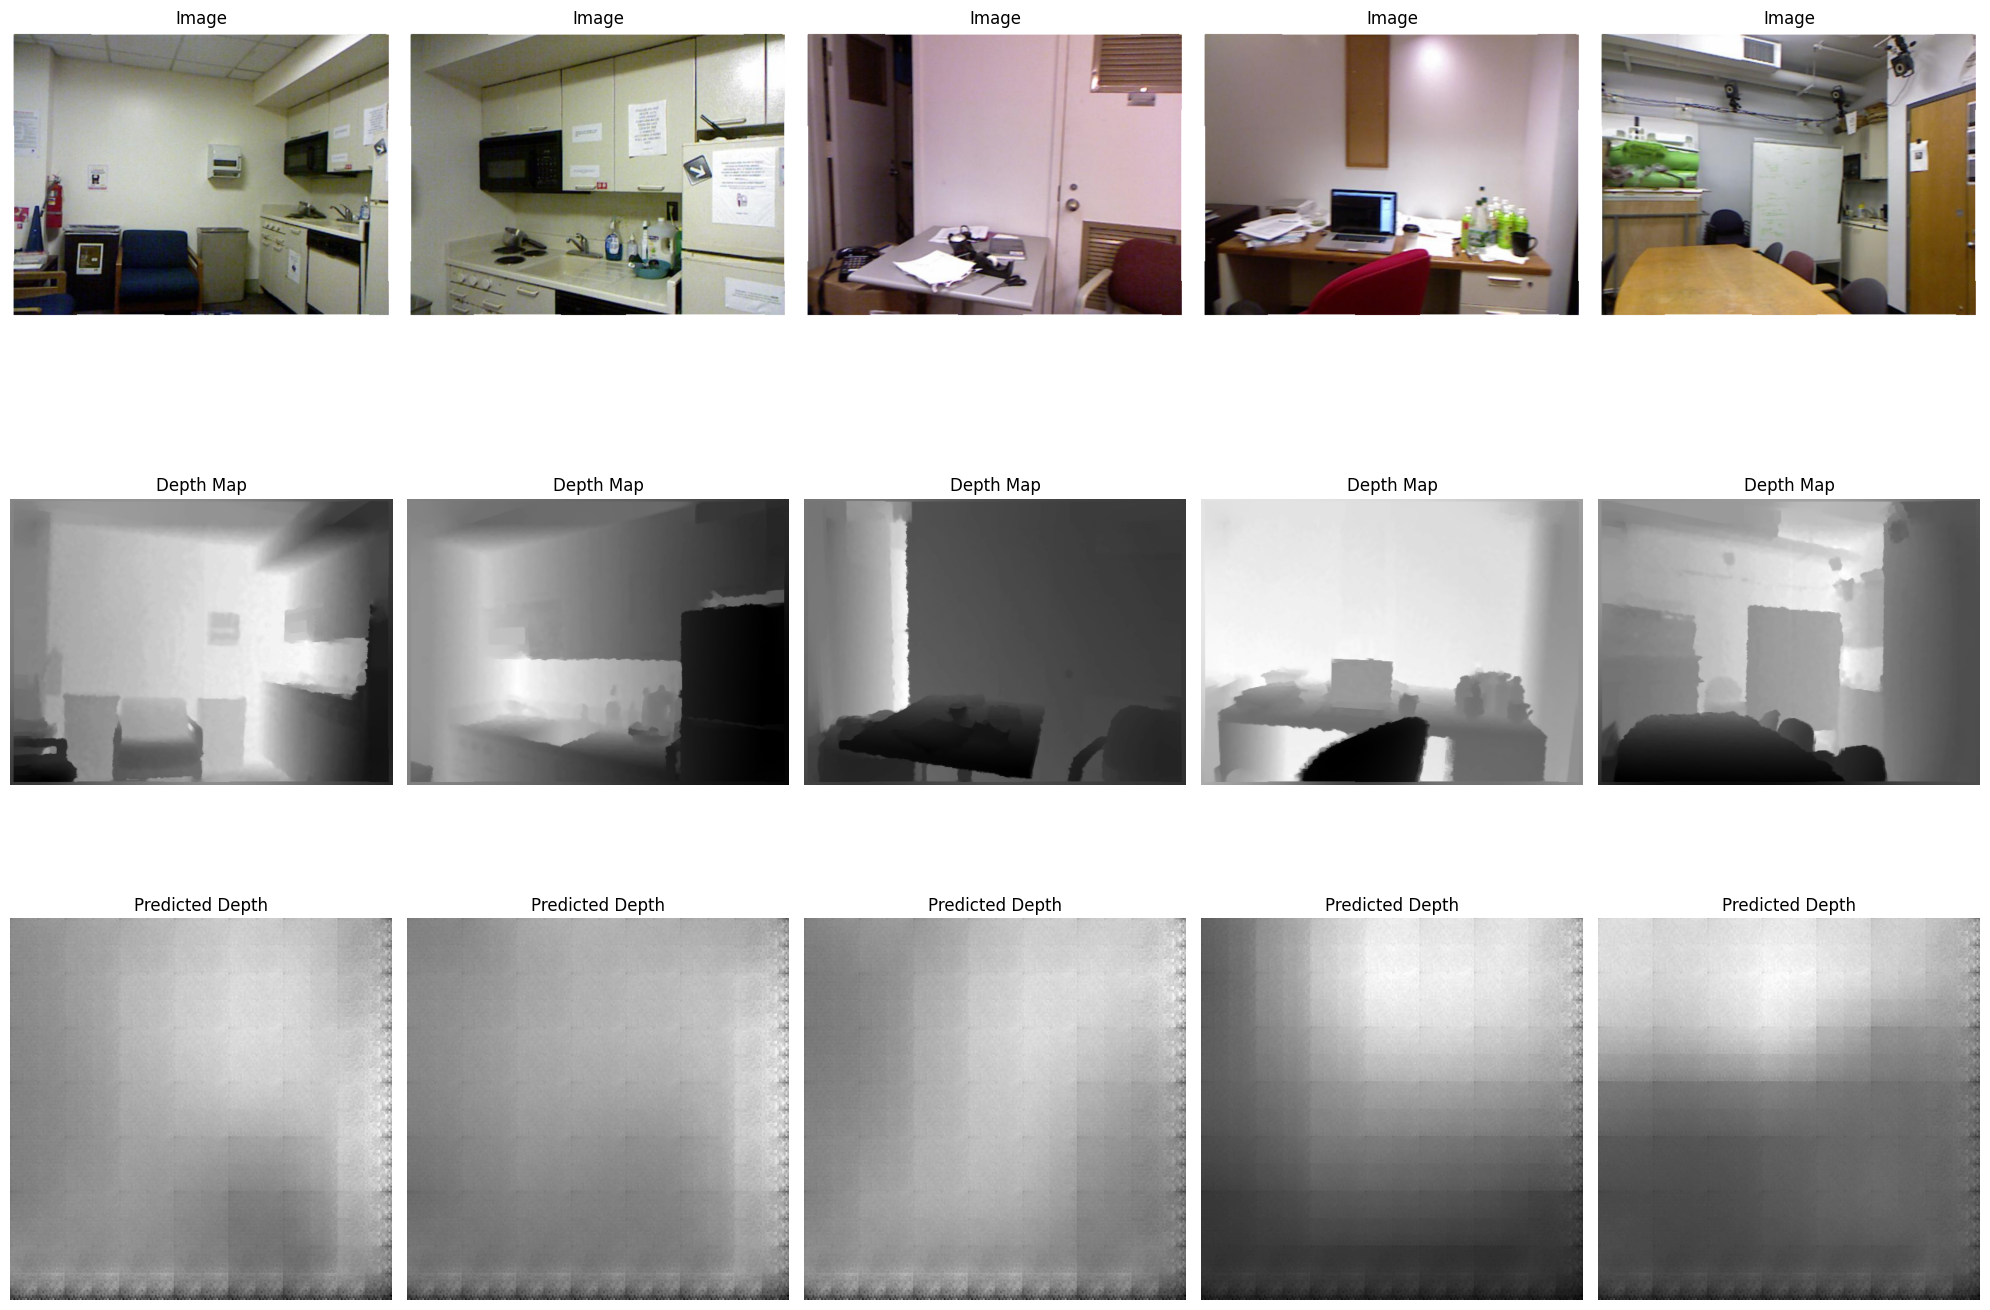

In [ ]:


def display_samples_with_predictions(data_dir, predictions, num_samples=5):
    images_dir = os.path.join(data_dir, 'images/train')
    depths_dir = os.path.join(data_dir, 'depths/train')
    image_paths = sorted([os.path.join(images_dir, name) for name in os.listdir(images_dir) if name.endswith('.p')])
    depth_paths = sorted([os.path.join(depths_dir, name) for name in os.listdir(depths_dir) if name.endswith('.p')])

    plt.figure(figsize=(20, 5 * 3))  # Adjust height for three rows
    for i in range(num_samples):
        image = pickle.load(open(image_paths[i], 'rb')).astype('uint8')
        depth = pickle.load(open(depth_paths[i], 'rb'))
        prediction = predictions[i].squeeze().cpu().numpy()

        # Normalize depth map for display
        normalized_depth = (depth - depth.min()) / (depth.max() - depth.min())
        normalized_prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min())

        # Display image
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        # Display ground truth depth map
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(normalized_depth, cmap='gray')
        plt.title('Depth Map')
        plt.axis('off')

        # Display predicted depth map
        plt.subplot(3, num_samples, i + 1 + num_samples * 2)
        plt.imshow(normalized_prediction, cmap='gray')
        plt.title('Predicted Depth')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


display_samples_with_predictions(data_dir, outputs, num_samples=5)


## Fourrier Transform

In [ ]:
import torch
import numpy as np
from skimage import transform
import math

class FDC:
    def __init__(self, model, depth_size=(224, 224), device='cpu'):
        self.weights = None
        self.biases = None
        self.model = model
        self.device = device
        self.depth_size = depth_size
        self.crop_ratios = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
        self.ncoeff = depth_size[0] * (math.floor(depth_size[1] / 2) + 1) * 2
        
    def merge_crops(self, crops):
        merged_crops = torch.empty((len(self.crop_ratios), *self.depth_size), device=self.device)
        quadrant_height = self.depth_size[0] // 2
        quadrant_width = self.depth_size[1] // 2

        for i, ratio in enumerate(self.crop_ratios):
            merged = torch.zeros(self.depth_size, device=self.device)
            weights = torch.zeros(self.depth_size, device=self.device)

            for j in range(4):
                # Adjusting the crop size to fill exactly one quadrant
                crop_size = (round(quadrant_height * ratio), round(quadrant_width * ratio))
                crop = transform.resize(crops[j].cpu().numpy(), crop_size, mode='reflect',
                                        anti_aliasing=True, preserve_range=True)
                crop = torch.from_numpy(crop).float().to(self.device)
                
                # Calculate start and end indices for placing the crop
                y, x = divmod(j, 2)
                start_y = y * quadrant_height
                start_x = x * quadrant_width
                end_y = start_y + crop_size[0]
                end_x = start_x + crop_size[1]

                # Ensure the crop is placed without exceeding the bounds of the merged tensor
                end_y = min(end_y, start_y + quadrant_height)
                end_x = min(end_x, start_x + quadrant_width)

                merged[start_y:end_y, start_x:end_x] += crop[:end_y - start_y, :end_x - start_x]
                weights[start_y:end_y, start_x:end_x] += 1

            # Avoid division by zero; divide only where weights are non-zero
            valid_weights = weights > 0
            merged[valid_weights] /= weights[valid_weights]

            merged_crops[i] = merged

        return merged_crops


In [ ]:
fdc = FDC(model, device=device)
# convert test_depth to torch tensor
test_depth = torch.tensor(test_depth)
print(test_depth.shape)
fdc.merge_crops(outputs).shape

torch.Size([5, 1, 224, 224])


/var/folders/8l/z2bjb9jj651bf5n7dpz3626c0000gn/T/ipykernel_47176/3353485953.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_depth = torch.tensor(test_depth)


RuntimeError: The size of tensor a (67) must match the size of tensor b (224) at non-singleton dimension 2